In [1]:
import pandas as pd
import numpy as np
import math
import os, sys
from io import StringIO
import warnings
import requests
from datetime import datetime, date
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from random import sample
from numpy.random import uniform

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn import cluster, linear_model, tree, neighbors, ensemble, svm
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold,\
                                    GridSearchCV, RepeatedStratifiedKFold,\
                                    RandomizedSearchCV
from sklearn import model_selection
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# XGB
from xgboost import XGBClassifier

# lightgbm
from lightgbm import LGBMClassifier

# catboost
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

In [2]:
train = pd.read_csv("train_s3TEQDk.csv", index_col="ID")
train.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
ID,,,,,,,,,,
NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [3]:
train.shape

(245725, 10)

In [4]:
test = pd.read_csv("test_mSzZ8RL.csv", index_col="ID")
test.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
ID,,,,,,,,,
VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [5]:
test.shape

(105312, 9)

In [6]:
target_name = "Is_Lead"

In [7]:
y = train.pop(target_name)
X = train

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,
                                                  stratify=y_train)

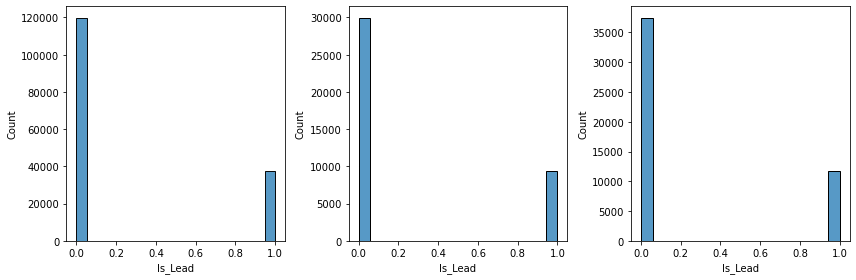

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
_ = sns.histplot(y_train, ax=axes[0])
_ = sns.histplot(y_val, ax=axes[1])
_ = sns.histplot(y_test, ax=axes[2])
plt.tight_layout()
plt.show()

In [10]:
def show_performance(estimator, X_train, y_train, X_val, y_val):
    # Predict
    y_train_pred = estimator.predict(X_train)
    y_train_probs = estimator.predict_proba(X_train)

    # Predict probabilities
    y_val_pred = estimator.predict(X_val)
    y_val_probs = estimator.predict_proba(X_val)

    # Display scores
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_val, y_val)
    print("Train Score: {}\nTest Score:{}".format(train_score, test_score))

    # Show classification report
    print("Train classification Report")
    print(metrics.classification_report(y_train, y_train_pred))
    
    print("Test classification Report")
    print(metrics.classification_report(y_val, y_val_pred))

    # Show ROC
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    disp = metrics.plot_roc_curve(estimator, X_train, y_train, ax=axes[0][0])
    axes[0][0].plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    axes[0][0].set(title='Receiver operating characteristic on train')
    disp = metrics.plot_roc_curve(estimator, X_val, y_val, ax=axes[0][1])
    axes[0][1].plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    axes[0][1].set(title='Receiver operating characteristic on test')

    # Show Precision-Recall
    disp = metrics.plot_precision_recall_curve(estimator, X_train, y_train, ax=axes[1][0])
    axes[1][0].set(title='Precision-Recall on train')
    disp = metrics.plot_precision_recall_curve(estimator, X_val, y_val, ax=axes[1][1])
    axes[1][1].set(title='Precision-Recall on test')
    plt.tight_layout()
    plt.show()

In [11]:
categorical = list(train.select_dtypes(exclude="number").columns)
categorical

['Gender',
 'Region_Code',
 'Occupation',
 'Channel_Code',
 'Credit_Product',
 'Is_Active']

In [12]:
numerical = list(train.select_dtypes(include="number").columns)
numerical

['Age', 'Vintage', 'Avg_Account_Balance']

In [13]:
# Define categorical pipeline
steps = [
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
]
cat_pipe = Pipeline(steps)
cat_pipe

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [14]:
# Define numerical pipeline
steps = [
    ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
]
num_pipe = Pipeline(steps=steps)
num_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

In [15]:
# Define numerical pipeline
steps = [
    ('imputer', SimpleImputer(strategy='median')),
]
num_pipe_wo_scale = Pipeline(steps=steps)
num_pipe_wo_scale

Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

In [16]:
# Fit column transformer to training data
preprocessor = ColumnTransformer(transformers=[('cat', cat_pipe, categorical),
                                               ('num', num_pipe, numerical)], n_jobs=-1)
preprocessor

ColumnTransformer(n_jobs=-1,
                  transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Gender', 'Region_Code', 'Occupation',
                                  'Channel_Code', 'Credit_Product',
                                  'Is_Active']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['Age', 'Vintage', 'Avg_Account_Balance'])])

In [17]:
n_splits = 5
scoring = 'roc_auc'

# Random Forest

In [18]:
# Combine categorical and numerical pipeline
steps = [
    ('preprocessor', preprocessor),
    ('rfc', ensemble.RandomForestClassifier(n_jobs=-1, class_weight='balanced', oob_score=True, ))
]
rfc_pipe = Pipeline(steps=steps)

rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Gender', 'Region_Code',
                                                   'Occupation', 'Channel_Code',
                                                   'Credit_Product',
                                                   'Is_Active']),
    

Train Score: 0.9998919015159222
Test Score:0.8525027978431173
Train classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    119960
           1       1.00      1.00      1.00     37304

    accuracy                           1.00    157264
   macro avg       1.00      1.00      1.00    157264
weighted avg       1.00      1.00      1.00    157264

Test classification Report
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     29990
           1       0.75      0.57      0.65      9326

    accuracy                           0.85     39316
   macro avg       0.81      0.76      0.78     39316
weighted avg       0.85      0.85      0.85     39316



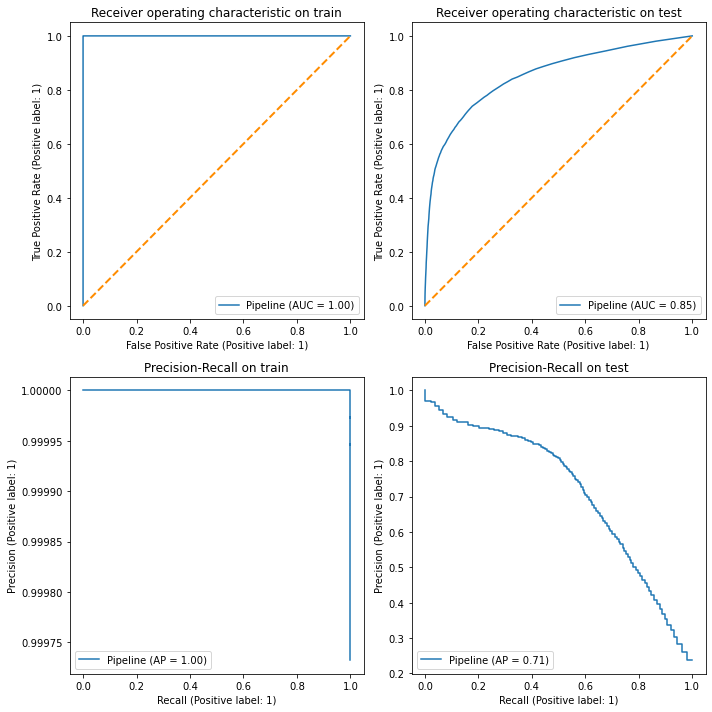

In [19]:
show_performance(rfc_pipe, X_train, y_train, X_val, y_val)

In [20]:
rfc_pipe.named_steps['rfc'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [21]:
rfc_pipe.named_steps['rfc'].oob_score_

0.8496477261165938

### Cross Validate Model

In [22]:
# define grid search
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=1, random_state=42)

scores = model_selection.cross_validate(rfc_pipe, X_train, y_train, cv=cv)
scores

{'fit_time': array([10.01556349,  9.98061538, 10.98190928, 10.98269415, 10.96783257]),
 'score_time': array([0.31664014, 0.40608215, 0.39714956, 0.41314673, 0.42393875]),
 'test_score': array([0.84948971, 0.85009379, 0.85168346, 0.85212857, 0.85129721])}

### Tune hyper-parameter

In [23]:
# define grid search
grid = {
    'rfc__n_estimators': stats.randint(50, 250),# default 100
    'rfc__max_depth': stats.randint(2,6), # default 3
}
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=1, random_state=42)

# grid_search = GridSearchCV(estimator=xgb_pipe, param_grid=grid, n_jobs=-1,
#                            cv=cv,scoring=scoring, error_score=0, verbose=1)
grid_search = RandomizedSearchCV(estimator=rfc_pipe, param_distributions=grid, n_jobs=-1,
                                 cv=cv,scoring=scoring, error_score=0, verbose=1)
grid_result_rfc = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [24]:
best_params = grid_result_rfc.best_params_
best_params

{'rfc__max_depth': 5, 'rfc__n_estimators': 90}

In [25]:
grid_result_rfc.best_estimator_.get_params()

{'memory': None,
 'steps': [('preprocessor', ColumnTransformer(n_jobs=-1,
                     transformers=[('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('encoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    ['Gender', 'Region_Code', 'Occupation',
                                     'Channel_Code', 'Credit_Product',
                                     'Is_Active']),
                                   ('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median'))]),
   

Train Score: 0.7991466578492217
Test Score:0.7994963882388849
Train classification Report
              precision    recall  f1-score   support

           0       0.92      0.80      0.86    119960
           1       0.55      0.79      0.65     37304

    accuracy                           0.80    157264
   macro avg       0.74      0.80      0.75    157264
weighted avg       0.84      0.80      0.81    157264

Test classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     29990
           1       0.55      0.79      0.65      9326

    accuracy                           0.80     39316
   macro avg       0.74      0.80      0.76     39316
weighted avg       0.84      0.80      0.81     39316



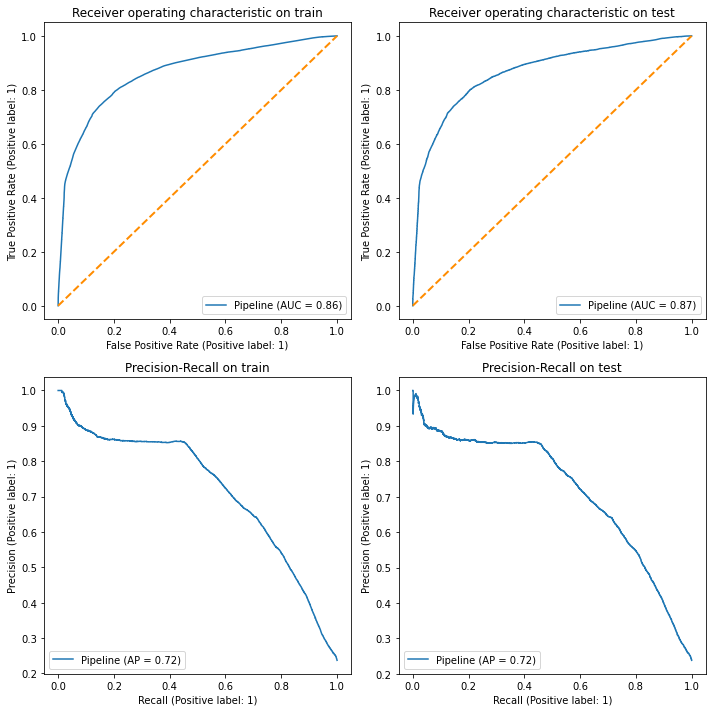

In [26]:
show_performance(grid_result_rfc.best_estimator_, X_train, y_train, X_val, y_val)

In [27]:
rfc_prediction = grid_result_rfc.best_estimator_.predict_proba(test)[:, 1]
rfc_prediction

array([0.33153117, 0.81788458, 0.178541  , ..., 0.33559136, 0.4137647 ,
       0.17959665])

In [28]:
rfc_prediction = pd.DataFrame(rfc_prediction, index=test.index, columns=[target_name])
rfc_prediction

,Is_Lead
ID,
VBENBARO,0.331531
CCMEWNKY,0.817885
VK3KGA9M,0.178541
TT8RPZVC,0.164375
SHQZEYTZ,0.149533
...,...
DBENJOYI,0.778828
CWQ72DWS,0.660741
HDESC8GU,0.335591


In [29]:
rfc_prediction.to_csv("rfc_prediction.csv", index=True)

# XGBoost

In [30]:
# Combine categorical and numerical pipeline
steps = [
    ('preprocessor', preprocessor),
    ('xgbc', XGBClassifier(objective='binary:logistic', n_jobs=-1,
                           use_label_encoder=False, scale_pos_weight=5,
                           num_parallel_tree=4))
]
xgb_pipe = Pipeline(steps=steps)

xgb_pipe.fit(X_train, y_train)

[22:43:01] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Gender', 'Region_Code',
                                                   'Occupation', 'Channel_Code',
                                                   'Credit_Product',
                                                   'Is_Active']),
    

Train Score: 0.7980148031335843
Test Score:0.7846932546545935
Train classification Report
              precision    recall  f1-score   support

           0       0.94      0.78      0.86    119960
           1       0.55      0.85      0.67     37304

    accuracy                           0.80    157264
   macro avg       0.75      0.81      0.76    157264
weighted avg       0.85      0.80      0.81    157264

Test classification Report
              precision    recall  f1-score   support

           0       0.93      0.77      0.85     29990
           1       0.53      0.82      0.64      9326

    accuracy                           0.78     39316
   macro avg       0.73      0.80      0.74     39316
weighted avg       0.84      0.78      0.80     39316



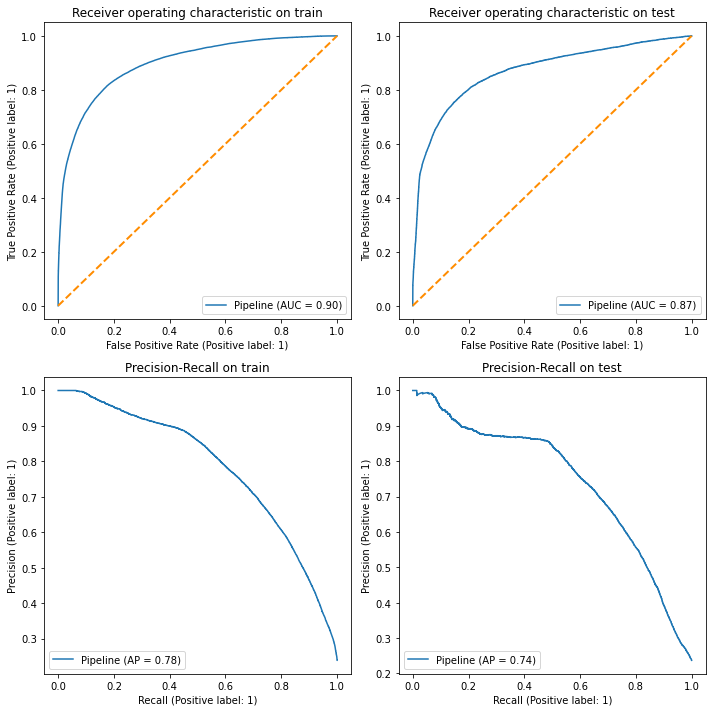

In [31]:
show_performance(xgb_pipe, X_train, y_train, X_val, y_val)

In [32]:
# # define grid search
# grid = {
#     'xgbc__n_estimators': stats.randint(100, 250),# default 100 #list(range(100, 501, 100)),
#     'xgbc__max_depth': stats.randint(2,6), # default 3
#     'xgbc__learning_rate': stats.uniform(3e-3, 3e-1), #[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
# }
# cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=1, random_state=42)

# # grid_search = GridSearchCV(estimator=xgb_pipe, param_grid=grid, n_jobs=-1,
# #                            cv=cv,scoring=scoring, error_score=0, verbose=1)
# grid_search = RandomizedSearchCV(estimator=xgb_pipe, param_distributions=grid, n_jobs=-1,
#                                  cv=cv,scoring=scoring, error_score=0, verbose=1)
# grid_result_xgb = grid_search.fit(X_train, y_train)

### Best Params:
{'xgbc__learning_rate': 0.05298155748922578,<br>
 'xgbc__max_depth': 4,<br>
 'xgbc__n_estimators': 220}<br>

In [33]:
best_params = {
    'xgbc__learning_rate': 0.05298155748922578,
    'xgbc__max_depth': 4,
    'xgbc__n_estimators': 220
}

In [34]:
xgb_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor', ColumnTransformer(n_jobs=-1,
                     transformers=[('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('encoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    ['Gender', 'Region_Code', 'Occupation',
                                     'Channel_Code', 'Credit_Product',
                                     'Is_Active']),
                                   ('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median'))]),
   

In [35]:
# Combine categorical and numerical pipeline
steps = [
    ('preprocessor', preprocessor),
    ('xgbc', XGBClassifier(objective='binary:logistic', n_jobs=-1,
                           use_label_encoder=False, scale_pos_weight=5,
                           num_parallel_tree=4, ))
]
xgb_pipe = Pipeline(steps=steps)
xgb_pipe.set_params(**best_params)

xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Gender', 'Region_Code',
                                                   'Occupation', 'Channel_Code',
                                                   'Credit_Product',
                                                   'Is_Active']),
    

[22:43:57] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Gender', 'Region_Code',
                                                   'Occupation', 'Channel_Code',
                                                   'Credit_Product',
                                                   'Is_Active']),
    

In [36]:
xgb_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor', ColumnTransformer(n_jobs=-1,
                     transformers=[('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('encoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    ['Gender', 'Region_Code', 'Occupation',
                                     'Channel_Code', 'Credit_Product',
                                     'Is_Active']),
                                   ('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median'))]),
   

Train Score: 0.7691652253535456
Test Score:0.7668124936412657
Train classification Report
              precision    recall  f1-score   support

           0       0.94      0.75      0.83    119960
           1       0.51      0.84      0.63     37304

    accuracy                           0.77    157264
   macro avg       0.72      0.79      0.73    157264
weighted avg       0.84      0.77      0.78    157264

Test classification Report
              precision    recall  f1-score   support

           0       0.94      0.74      0.83     29990
           1       0.51      0.84      0.63      9326

    accuracy                           0.77     39316
   macro avg       0.72      0.79      0.73     39316
weighted avg       0.84      0.77      0.78     39316



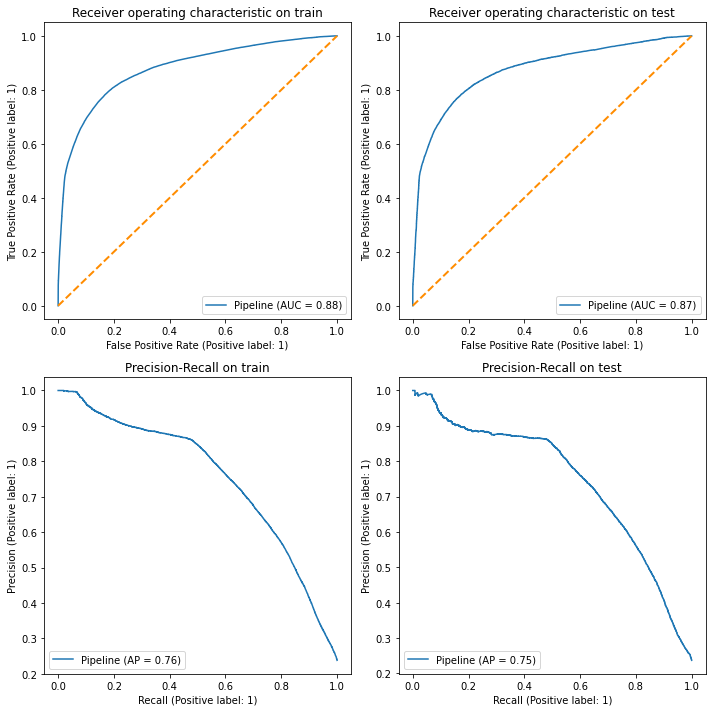

In [37]:
show_performance(xgb_pipe, X_train, y_train, X_val, y_val)

In [38]:
# show_performance(grid_result_xgb.best_estimator_, X_train, y_train, X_test, y_test)

In [39]:
# xgb_prediction = grid_result_xgb.best_estimator_.predict(test)
# xgb_prediction

In [40]:
xgb_prediction = xgb_pipe.predict_proba(test)[:, 1]
xgb_prediction

array([0.22754203, 0.9695181 , 0.24383606, ..., 0.28489327, 0.61283815,
       0.20216471], dtype=float32)

In [41]:
xgb_prediction = pd.DataFrame(xgb_prediction, index=test.index, columns=[target_name])
xgb_prediction

,Is_Lead
ID,
VBENBARO,0.227542
CCMEWNKY,0.969518
VK3KGA9M,0.243836
TT8RPZVC,0.110443
SHQZEYTZ,0.109376
...,...
DBENJOYI,0.995679
CWQ72DWS,0.869927
HDESC8GU,0.284893


In [42]:
xgb_prediction.to_csv("xgb_prediction.csv", index=True)

# LightGBM

In [43]:
# Combine categorical and numerical pipeline
steps = [
    ('preprocessor', preprocessor),
    ('lgbc', LGBMClassifier(n_jobs=-1, class_weight='balanced',
                            scale_pos_weight=5))
]
lgbm_pipe = Pipeline(steps=steps)

lgbm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Gender', 'Region_Code',
                                                   'Occupation', 'Channel_Code',
                                                   'Credit_Product',
                                                   'Is_Active']),
    

Train Score: 0.5957434632210805
Test Score:0.583935293519178
Train classification Report
              precision    recall  f1-score   support

           0       0.96      0.49      0.65    119960
           1       0.36      0.94      0.52     37304

    accuracy                           0.60    157264
   macro avg       0.66      0.71      0.59    157264
weighted avg       0.82      0.60      0.62    157264

Test classification Report
              precision    recall  f1-score   support

           0       0.95      0.48      0.64     29990
           1       0.35      0.92      0.51      9326

    accuracy                           0.58     39316
   macro avg       0.65      0.70      0.57     39316
weighted avg       0.81      0.58      0.61     39316



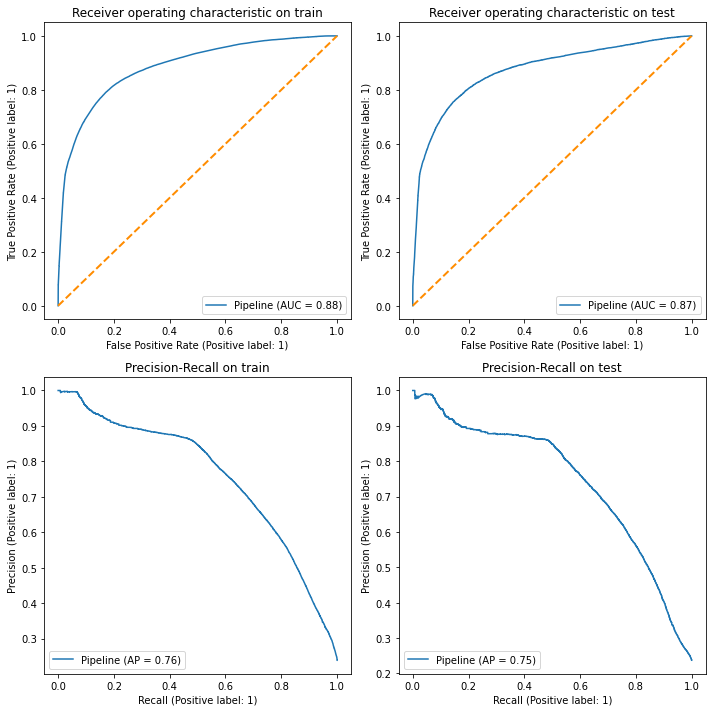

In [44]:
show_performance(lgbm_pipe, X_train, y_train, X_val, y_val)

In [45]:
lgbm_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor', ColumnTransformer(n_jobs=-1,
                     transformers=[('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('encoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    ['Gender', 'Region_Code', 'Occupation',
                                     'Channel_Code', 'Credit_Product',
                                     'Is_Active']),
                                   ('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median'))]),
   

In [46]:
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=1, random_state=42)

scores = model_selection.cross_validate(lgbm_pipe, X_train, y_train, cv=cv)
scores

{'fit_time': array([0.99749875, 0.92965388, 1.02683902, 0.91131473, 0.9331193 ]),
 'score_time': array([0.14064455, 0.1379714 , 0.14171767, 0.14846158, 0.14533877]),
 'test_score': array([0.584205  , 0.58560392, 0.58286968, 0.58700283, 0.59935775])}

In [47]:
# define grid search
grid = {
    'lgbc__n_estimators': stats.randint(50, 250),
    'lgbc__max_depth': stats.randint(2, 7),
    'lgbc__num_leaves': stats.randint(10, 40),
    'lgbc__learning_rate': stats.uniform(1e-3, 1e1),#[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
}

grid_search = RandomizedSearchCV(estimator=lgbm_pipe, param_distributions=grid,
                                 n_jobs=-1, cv=cv)

# grid_search = GridSearchCV(estimator=lgbm_pipe, param_grid=grid, n_jobs=-1,
#                            cv=cv,scoring=scoring, error_score=0, verbose=1)

In [48]:
grid_result_lgb = grid_search.fit(X_train, y_train)

In [49]:
grid_result_lgb.best_params_

{'lgbc__learning_rate': 0.03430293345215285,
 'lgbc__max_depth': 5,
 'lgbc__n_estimators': 215,
 'lgbc__num_leaves': 26}

Train Score: 0.5966591209685624
Test Score:0.5918709939973548
Train classification Report
              precision    recall  f1-score   support

           0       0.96      0.49      0.65    119960
           1       0.36      0.93      0.52     37304

    accuracy                           0.60    157264
   macro avg       0.66      0.71      0.59    157264
weighted avg       0.82      0.60      0.62    157264

Test classification Report
              precision    recall  f1-score   support

           0       0.95      0.49      0.65     29990
           1       0.36      0.92      0.52      9326

    accuracy                           0.59     39316
   macro avg       0.66      0.71      0.58     39316
weighted avg       0.81      0.59      0.62     39316



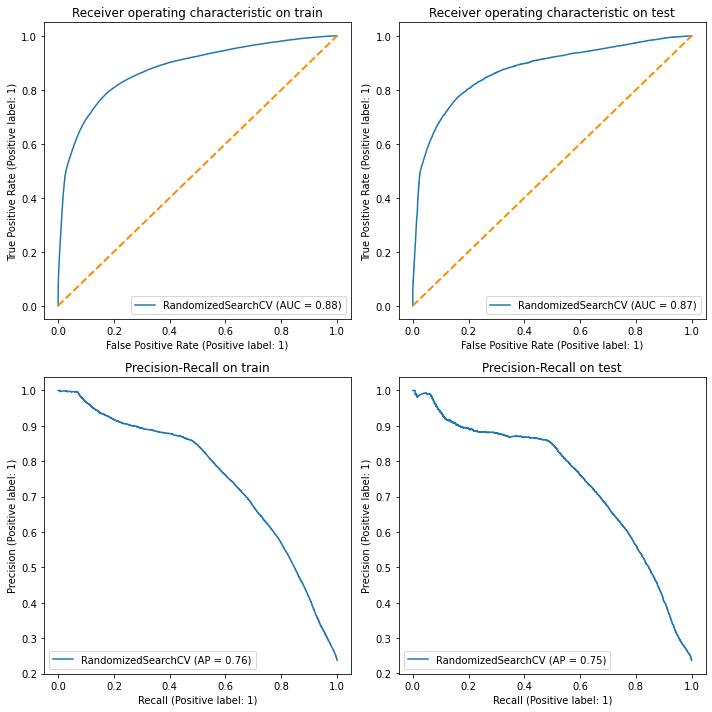

In [50]:
show_performance(grid_result_lgb, X_train, y_train, X_val, y_val)

In [51]:
lgb_prediction = grid_result_lgb.best_estimator_.predict_proba(test)[:, 1]
lgb_prediction

array([0.42225577, 0.99004085, 0.49280897, ..., 0.50980325, 0.82089123,
       0.46883383])

In [52]:
lgb_prediction = pd.DataFrame(lgb_prediction, index=test.index, columns=[target_name])
lgb_prediction

,Is_Lead
ID,
VBENBARO,0.422256
CCMEWNKY,0.990041
VK3KGA9M,0.492809
TT8RPZVC,0.290302
SHQZEYTZ,0.268369
...,...
DBENJOYI,0.997792
CWQ72DWS,0.942401
HDESC8GU,0.509803


In [53]:
lgb_prediction.to_csv("lgb_prediction.csv", index=True)

# Catboost

In [54]:
class SimpleImputerFeatureNames(SimpleImputer):

    def fit(self, X, y=None):
        if hasattr(X, "columns"):
            self._feature_names = np.asarray(X.columns)
        else:
            self._feature_names = [d for d in range(X.shape[1])]
        if hasattr(X, "index"):
            self._indexes = np.asarray(X.index)
        else:
            self._indexes = [d for d in range(X.shape[0])]
        super().fit(X, y)
        return self

    def fit_transform(self, X, y=None):
        _temp = super().fit_transform(X, y)
        return pd.DataFrame(_temp,
                            index=self._indexes,
                            columns=self._feature_names)

    def get_feature_names(self):
        return self._feature_names

In [55]:
simple = SimpleImputerFeatureNames(strategy='constant', fill_value='missing')

In [56]:
print('I see %i GPU devices' % get_gpu_device_count())

I see 1 GPU devices


In [57]:
steps = [
    ('preprocessor', simple),
    ('cat', CatBoostClassifier(task_type="GPU" if get_gpu_device_count() != 0 else "CPU",
                               class_weights=[0.2,0.8], eval_metric='AUC'))
]
catc_pipe = Pipeline(steps)
catc_pipe.fit(X_train, y_train, cat__cat_features=categorical)

Learning rate set to 0.025525
0:	learn: 0.8455003	total: 66.9ms	remaining: 1m 6s
1:	learn: 0.8463482	total: 109ms	remaining: 54.2s
2:	learn: 0.8465161	total: 151ms	remaining: 50.3s
3:	learn: 0.8466841	total: 193ms	remaining: 48s
4:	learn: 0.8466502	total: 233ms	remaining: 46.3s
5:	learn: 0.8466742	total: 272ms	remaining: 45s
6:	learn: 0.8467487	total: 319ms	remaining: 45.3s
7:	learn: 0.8467433	total: 359ms	remaining: 44.5s
8:	learn: 0.8467285	total: 398ms	remaining: 43.8s
9:	learn: 0.8467821	total: 436ms	remaining: 43.2s
10:	learn: 0.8471248	total: 474ms	remaining: 42.6s
11:	learn: 0.8471320	total: 514ms	remaining: 42.3s
12:	learn: 0.8472492	total: 552ms	remaining: 41.9s
13:	learn: 0.8473358	total: 590ms	remaining: 41.6s
14:	learn: 0.8474847	total: 628ms	remaining: 41.2s
15:	learn: 0.8474647	total: 665ms	remaining: 40.9s
16:	learn: 0.8474740	total: 703ms	remaining: 40.7s
17:	learn: 0.8474935	total: 744ms	remaining: 40.6s
18:	learn: 0.8475103	total: 782ms	remaining: 40.4s
19:	learn: 0.8

164:	learn: 0.8688293	total: 6.96s	remaining: 35.2s
165:	learn: 0.8688502	total: 7.01s	remaining: 35.2s
166:	learn: 0.8688898	total: 7.05s	remaining: 35.2s
167:	learn: 0.8689350	total: 7.1s	remaining: 35.2s
168:	learn: 0.8689535	total: 7.15s	remaining: 35.1s
169:	learn: 0.8689844	total: 7.2s	remaining: 35.1s
170:	learn: 0.8690096	total: 7.24s	remaining: 35.1s
171:	learn: 0.8690946	total: 7.28s	remaining: 35s
172:	learn: 0.8691154	total: 7.32s	remaining: 35s
173:	learn: 0.8691782	total: 7.36s	remaining: 34.9s
174:	learn: 0.8692334	total: 7.4s	remaining: 34.9s
175:	learn: 0.8693138	total: 7.44s	remaining: 34.8s
176:	learn: 0.8693332	total: 7.48s	remaining: 34.8s
177:	learn: 0.8693689	total: 7.53s	remaining: 34.8s
178:	learn: 0.8694010	total: 7.58s	remaining: 34.8s
179:	learn: 0.8694282	total: 7.62s	remaining: 34.7s
180:	learn: 0.8694565	total: 7.67s	remaining: 34.7s
181:	learn: 0.8694770	total: 7.71s	remaining: 34.7s
182:	learn: 0.8695011	total: 7.76s	remaining: 34.7s
183:	learn: 0.86952

323:	learn: 0.8723607	total: 13.7s	remaining: 28.5s
324:	learn: 0.8723722	total: 13.7s	remaining: 28.4s
325:	learn: 0.8723822	total: 13.7s	remaining: 28.4s
326:	learn: 0.8723889	total: 13.8s	remaining: 28.4s
327:	learn: 0.8724091	total: 13.8s	remaining: 28.3s
328:	learn: 0.8724543	total: 13.9s	remaining: 28.3s
329:	learn: 0.8724639	total: 13.9s	remaining: 28.2s
330:	learn: 0.8724733	total: 14s	remaining: 28.2s
331:	learn: 0.8724851	total: 14s	remaining: 28.2s
332:	learn: 0.8725001	total: 14s	remaining: 28.1s
333:	learn: 0.8725320	total: 14.1s	remaining: 28.1s
334:	learn: 0.8725366	total: 14.1s	remaining: 28s
335:	learn: 0.8725432	total: 14.1s	remaining: 28s
336:	learn: 0.8725582	total: 14.2s	remaining: 27.9s
337:	learn: 0.8725708	total: 14.2s	remaining: 27.8s
338:	learn: 0.8725921	total: 14.3s	remaining: 27.8s
339:	learn: 0.8726082	total: 14.3s	remaining: 27.8s
340:	learn: 0.8726159	total: 14.3s	remaining: 27.7s
341:	learn: 0.8726290	total: 14.4s	remaining: 27.7s
342:	learn: 0.8726596	

484:	learn: 0.8744678	total: 20.2s	remaining: 21.5s
485:	learn: 0.8744744	total: 20.3s	remaining: 21.4s
486:	learn: 0.8744906	total: 20.3s	remaining: 21.4s
487:	learn: 0.8745005	total: 20.3s	remaining: 21.3s
488:	learn: 0.8745136	total: 20.4s	remaining: 21.3s
489:	learn: 0.8745242	total: 20.4s	remaining: 21.3s
490:	learn: 0.8745342	total: 20.5s	remaining: 21.2s
491:	learn: 0.8745762	total: 20.5s	remaining: 21.2s
492:	learn: 0.8745880	total: 20.5s	remaining: 21.1s
493:	learn: 0.8745906	total: 20.6s	remaining: 21.1s
494:	learn: 0.8745963	total: 20.6s	remaining: 21s
495:	learn: 0.8746034	total: 20.7s	remaining: 21s
496:	learn: 0.8746164	total: 20.7s	remaining: 21s
497:	learn: 0.8746328	total: 20.7s	remaining: 20.9s
498:	learn: 0.8746452	total: 20.8s	remaining: 20.9s
499:	learn: 0.8746471	total: 20.8s	remaining: 20.8s
500:	learn: 0.8746511	total: 20.9s	remaining: 20.8s
501:	learn: 0.8746620	total: 20.9s	remaining: 20.7s
502:	learn: 0.8746708	total: 20.9s	remaining: 20.7s
503:	learn: 0.8746

644:	learn: 0.8760147	total: 26.6s	remaining: 14.7s
645:	learn: 0.8760338	total: 26.7s	remaining: 14.6s
646:	learn: 0.8760408	total: 26.7s	remaining: 14.6s
647:	learn: 0.8760468	total: 26.8s	remaining: 14.6s
648:	learn: 0.8760514	total: 26.8s	remaining: 14.5s
649:	learn: 0.8760585	total: 26.9s	remaining: 14.5s
650:	learn: 0.8760628	total: 26.9s	remaining: 14.4s
651:	learn: 0.8760653	total: 27s	remaining: 14.4s
652:	learn: 0.8760760	total: 27.1s	remaining: 14.4s
653:	learn: 0.8760802	total: 27.1s	remaining: 14.3s
654:	learn: 0.8760882	total: 27.2s	remaining: 14.3s
655:	learn: 0.8760920	total: 27.2s	remaining: 14.3s
656:	learn: 0.8761086	total: 27.2s	remaining: 14.2s
657:	learn: 0.8761135	total: 27.3s	remaining: 14.2s
658:	learn: 0.8761189	total: 27.3s	remaining: 14.1s
659:	learn: 0.8761323	total: 27.4s	remaining: 14.1s
660:	learn: 0.8761376	total: 27.4s	remaining: 14.1s
661:	learn: 0.8761486	total: 27.4s	remaining: 14s
662:	learn: 0.8761572	total: 27.5s	remaining: 14s
663:	learn: 0.8761

804:	learn: 0.8773350	total: 33.2s	remaining: 8.04s
805:	learn: 0.8773392	total: 33.2s	remaining: 8s
806:	learn: 0.8773419	total: 33.3s	remaining: 7.96s
807:	learn: 0.8773459	total: 33.3s	remaining: 7.92s
808:	learn: 0.8773499	total: 33.3s	remaining: 7.87s
809:	learn: 0.8773538	total: 33.4s	remaining: 7.83s
810:	learn: 0.8773597	total: 33.4s	remaining: 7.79s
811:	learn: 0.8773642	total: 33.5s	remaining: 7.75s
812:	learn: 0.8773666	total: 33.5s	remaining: 7.71s
813:	learn: 0.8773718	total: 33.6s	remaining: 7.67s
814:	learn: 0.8773722	total: 33.6s	remaining: 7.62s
815:	learn: 0.8773816	total: 33.6s	remaining: 7.58s
816:	learn: 0.8773930	total: 33.7s	remaining: 7.54s
817:	learn: 0.8774128	total: 33.7s	remaining: 7.5s
818:	learn: 0.8774139	total: 33.7s	remaining: 7.46s
819:	learn: 0.8774217	total: 33.8s	remaining: 7.42s
820:	learn: 0.8774311	total: 33.8s	remaining: 7.38s
821:	learn: 0.8774373	total: 33.9s	remaining: 7.33s
822:	learn: 0.8774449	total: 33.9s	remaining: 7.29s
823:	learn: 0.87

965:	learn: 0.8784510	total: 39.6s	remaining: 1.39s
966:	learn: 0.8784596	total: 39.6s	remaining: 1.35s
967:	learn: 0.8784678	total: 39.6s	remaining: 1.31s
968:	learn: 0.8784724	total: 39.7s	remaining: 1.27s
969:	learn: 0.8784827	total: 39.7s	remaining: 1.23s
970:	learn: 0.8784890	total: 39.7s	remaining: 1.19s
971:	learn: 0.8784928	total: 39.8s	remaining: 1.15s
972:	learn: 0.8784963	total: 39.8s	remaining: 1.1s
973:	learn: 0.8785008	total: 39.9s	remaining: 1.06s
974:	learn: 0.8785061	total: 39.9s	remaining: 1.02s
975:	learn: 0.8785118	total: 39.9s	remaining: 982ms
976:	learn: 0.8785125	total: 40s	remaining: 941ms
977:	learn: 0.8785257	total: 40s	remaining: 900ms
978:	learn: 0.8785310	total: 40s	remaining: 859ms
979:	learn: 0.8785354	total: 40.1s	remaining: 818ms
980:	learn: 0.8785415	total: 40.1s	remaining: 777ms
981:	learn: 0.8785457	total: 40.2s	remaining: 736ms
982:	learn: 0.8785500	total: 40.2s	remaining: 695ms
983:	learn: 0.8785632	total: 40.3s	remaining: 655ms
984:	learn: 0.87856

Pipeline(steps=[('preprocessor',
                 SimpleImputerFeatureNames(fill_value='missing',
                                           strategy='constant')),
                ('cat',
                 <catboost.core.CatBoostClassifier object at 0x7fe40dfb0250>)])

Train Score: 0.8011623766405535
Test Score:0.7973089836199003
Train classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86    119960
           1       0.56      0.81      0.66     37304

    accuracy                           0.80    157264
   macro avg       0.74      0.80      0.76    157264
weighted avg       0.84      0.80      0.81    157264

Test classification Report
              precision    recall  f1-score   support

           0       0.93      0.79      0.86     29990
           1       0.55      0.80      0.65      9326

    accuracy                           0.80     39316
   macro avg       0.74      0.80      0.76     39316
weighted avg       0.84      0.80      0.81     39316



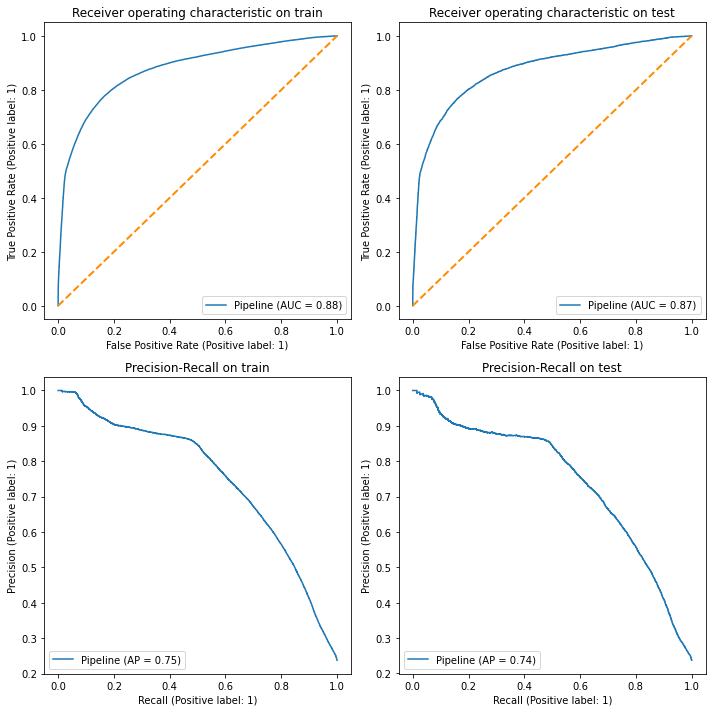

In [58]:
show_performance(catc_pipe, X_train, y_train, X_val, y_val)

In [59]:
catc_pipe.named_steps['cat'].get_params()

{'class_weights': [0.2, 0.8], 'eval_metric': 'AUC', 'task_type': 'GPU'}

In [60]:
# define grid search
grid = {
    'cat__n_estimators': stats.randint(100, 250),# default 100 #list(range(100, 501, 100)),
    'cat__max_depth': stats.randint(2,6), # default 3
    'cat__learning_rate': stats.uniform(3e-3, 3e-1), #[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
}

grid_search = RandomizedSearchCV(estimator=catc_pipe, param_distributions=grid,# n_jobs=-1,
                                 cv=cv,scoring=scoring, error_score=0, verbose=1)

# grid_search = GridSearchCV(estimator=catc_pipe, param_grid=grid, n_jobs=-1,
#                            cv=cv,scoring=scoring, error_score=0, verbose=1)

grid_result_catc = grid_search.fit(X_train, y_train, cat__cat_features=categorical)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.7756920	total: 10.9ms	remaining: 1.35s
1:	learn: 0.7807140	total: 21.4ms	remaining: 1.3s
2:	learn: 0.7808269	total: 28.6ms	remaining: 1.15s
3:	learn: 0.7827874	total: 35.1ms	remaining: 1.05s
4:	learn: 0.8115668	total: 41.6ms	remaining: 989ms
5:	learn: 0.8453892	total: 47.9ms	remaining: 943ms
6:	learn: 0.8472454	total: 54.3ms	remaining: 908ms
7:	learn: 0.8472909	total: 60.5ms	remaining: 877ms
8:	learn: 0.8477591	total: 66.4ms	remaining: 848ms
9:	learn: 0.8478895	total: 72.8ms	remaining: 830ms
10:	learn: 0.8478912	total: 79.1ms	remaining: 813ms
11:	learn: 0.8547722	total: 85.2ms	remaining: 796ms
12:	learn: 0.8549396	total: 91.5ms	remaining: 782ms
13:	learn: 0.8551210	total: 97.8ms	remaining: 769ms
14:	learn: 0.8552173	total: 104ms	remaining: 757ms
15:	learn: 0.8557292	total: 111ms	remaining: 747ms
16:	learn: 0.8559974	total: 117ms	remaining: 736ms
17:	learn: 0.8563822	total: 123ms	remaining: 726ms
18:	learn: 0.85638

35:	learn: 0.8609555	total: 205ms	remaining: 501ms
36:	learn: 0.8617529	total: 211ms	remaining: 496ms
37:	learn: 0.8618214	total: 217ms	remaining: 490ms
38:	learn: 0.8620901	total: 222ms	remaining: 485ms
39:	learn: 0.8622842	total: 228ms	remaining: 478ms
40:	learn: 0.8627203	total: 233ms	remaining: 473ms
41:	learn: 0.8628794	total: 239ms	remaining: 466ms
42:	learn: 0.8630745	total: 245ms	remaining: 461ms
43:	learn: 0.8631356	total: 250ms	remaining: 455ms
44:	learn: 0.8634578	total: 256ms	remaining: 449ms
45:	learn: 0.8639421	total: 261ms	remaining: 443ms
46:	learn: 0.8643760	total: 266ms	remaining: 436ms
47:	learn: 0.8648933	total: 271ms	remaining: 430ms
48:	learn: 0.8650467	total: 277ms	remaining: 423ms
49:	learn: 0.8651715	total: 282ms	remaining: 417ms
50:	learn: 0.8655926	total: 287ms	remaining: 411ms
51:	learn: 0.8656203	total: 292ms	remaining: 405ms
52:	learn: 0.8657712	total: 298ms	remaining: 399ms
53:	learn: 0.8658873	total: 303ms	remaining: 393ms
54:	learn: 0.8659164	total: 308

73:	learn: 0.8658983	total: 411ms	remaining: 277ms
74:	learn: 0.8659383	total: 417ms	remaining: 272ms
75:	learn: 0.8660702	total: 422ms	remaining: 267ms
76:	learn: 0.8661368	total: 428ms	remaining: 261ms
77:	learn: 0.8661568	total: 434ms	remaining: 256ms
78:	learn: 0.8663998	total: 439ms	remaining: 250ms
79:	learn: 0.8664653	total: 445ms	remaining: 245ms
80:	learn: 0.8664439	total: 451ms	remaining: 239ms
81:	learn: 0.8664374	total: 457ms	remaining: 234ms
82:	learn: 0.8664657	total: 463ms	remaining: 229ms
83:	learn: 0.8665190	total: 470ms	remaining: 224ms
84:	learn: 0.8665510	total: 475ms	remaining: 218ms
85:	learn: 0.8665719	total: 481ms	remaining: 213ms
86:	learn: 0.8668488	total: 487ms	remaining: 207ms
87:	learn: 0.8668952	total: 493ms	remaining: 202ms
88:	learn: 0.8669042	total: 498ms	remaining: 196ms
89:	learn: 0.8669633	total: 505ms	remaining: 191ms
90:	learn: 0.8670292	total: 510ms	remaining: 185ms
91:	learn: 0.8670905	total: 516ms	remaining: 180ms
92:	learn: 0.8671158	total: 522

0:	learn: 0.7765529	total: 6.2ms	remaining: 763ms
1:	learn: 0.7803843	total: 11.6ms	remaining: 707ms
2:	learn: 0.7819659	total: 17.1ms	remaining: 689ms
3:	learn: 0.8286413	total: 22.4ms	remaining: 671ms
4:	learn: 0.8456804	total: 27.8ms	remaining: 661ms
5:	learn: 0.8403524	total: 33ms	remaining: 650ms
6:	learn: 0.8401986	total: 38.7ms	remaining: 647ms
7:	learn: 0.8455196	total: 44.2ms	remaining: 642ms
8:	learn: 0.8458279	total: 49.5ms	remaining: 632ms
9:	learn: 0.8481446	total: 54.7ms	remaining: 623ms
10:	learn: 0.8541715	total: 60.3ms	remaining: 619ms
11:	learn: 0.8548328	total: 65.8ms	remaining: 614ms
12:	learn: 0.8548338	total: 71.2ms	remaining: 608ms
13:	learn: 0.8547733	total: 76.8ms	remaining: 603ms
14:	learn: 0.8551309	total: 82ms	remaining: 596ms
15:	learn: 0.8551405	total: 87.7ms	remaining: 592ms
16:	learn: 0.8554662	total: 93.4ms	remaining: 588ms
17:	learn: 0.8559294	total: 98.7ms	remaining: 581ms
18:	learn: 0.8561368	total: 104ms	remaining: 574ms
19:	learn: 0.8562271	total: 

66:	learn: 0.8662435	total: 406ms	remaining: 255ms
67:	learn: 0.8663024	total: 413ms	remaining: 249ms
68:	learn: 0.8664586	total: 419ms	remaining: 243ms
69:	learn: 0.8666480	total: 425ms	remaining: 237ms
70:	learn: 0.8666972	total: 432ms	remaining: 231ms
71:	learn: 0.8667558	total: 439ms	remaining: 226ms
72:	learn: 0.8668775	total: 445ms	remaining: 220ms
73:	learn: 0.8669292	total: 451ms	remaining: 213ms
74:	learn: 0.8669501	total: 457ms	remaining: 207ms
75:	learn: 0.8671525	total: 463ms	remaining: 201ms
76:	learn: 0.8673822	total: 469ms	remaining: 195ms
77:	learn: 0.8674076	total: 475ms	remaining: 189ms
78:	learn: 0.8674491	total: 480ms	remaining: 182ms
79:	learn: 0.8676067	total: 486ms	remaining: 176ms
80:	learn: 0.8676290	total: 492ms	remaining: 170ms
81:	learn: 0.8677389	total: 498ms	remaining: 164ms
82:	learn: 0.8677407	total: 504ms	remaining: 158ms
83:	learn: 0.8681414	total: 510ms	remaining: 152ms
84:	learn: 0.8683118	total: 516ms	remaining: 146ms
85:	learn: 0.8683248	total: 522

32:	learn: 0.8591758	total: 208ms	remaining: 479ms
33:	learn: 0.8593452	total: 214ms	remaining: 472ms
34:	learn: 0.8595958	total: 220ms	remaining: 465ms
35:	learn: 0.8597177	total: 226ms	remaining: 458ms
36:	learn: 0.8597273	total: 232ms	remaining: 452ms
37:	learn: 0.8598975	total: 238ms	remaining: 445ms
38:	learn: 0.8600771	total: 244ms	remaining: 438ms
39:	learn: 0.8603092	total: 253ms	remaining: 437ms
40:	learn: 0.8610856	total: 262ms	remaining: 435ms
41:	learn: 0.8614418	total: 268ms	remaining: 428ms
42:	learn: 0.8617831	total: 275ms	remaining: 421ms
43:	learn: 0.8622421	total: 280ms	remaining: 414ms
44:	learn: 0.8623267	total: 286ms	remaining: 407ms
45:	learn: 0.8624796	total: 292ms	remaining: 400ms
46:	learn: 0.8625695	total: 298ms	remaining: 393ms
47:	learn: 0.8626114	total: 304ms	remaining: 386ms
48:	learn: 0.8626937	total: 310ms	remaining: 379ms
49:	learn: 0.8627164	total: 316ms	remaining: 372ms
50:	learn: 0.8629559	total: 321ms	remaining: 365ms
51:	learn: 0.8630824	total: 327

97:	learn: 0.8689180	total: 612ms	remaining: 68.7ms
98:	learn: 0.8690318	total: 620ms	remaining: 62.6ms
99:	learn: 0.8690549	total: 626ms	remaining: 56.3ms
100:	learn: 0.8691575	total: 632ms	remaining: 50ms
101:	learn: 0.8691739	total: 639ms	remaining: 43.8ms
102:	learn: 0.8692930	total: 645ms	remaining: 37.6ms
103:	learn: 0.8693115	total: 652ms	remaining: 31.3ms
104:	learn: 0.8693682	total: 658ms	remaining: 25.1ms
105:	learn: 0.8693775	total: 664ms	remaining: 18.8ms
106:	learn: 0.8694346	total: 671ms	remaining: 12.5ms
107:	learn: 0.8694757	total: 677ms	remaining: 6.27ms
108:	learn: 0.8694990	total: 683ms	remaining: 0us
0:	learn: 0.7774301	total: 6.94ms	remaining: 750ms
1:	learn: 0.7824219	total: 13ms	remaining: 694ms
2:	learn: 0.8435243	total: 19.7ms	remaining: 694ms
3:	learn: 0.8414690	total: 25.4ms	remaining: 667ms
4:	learn: 0.8402473	total: 31.4ms	remaining: 653ms
5:	learn: 0.8411301	total: 38.4ms	remaining: 659ms
6:	learn: 0.8506012	total: 44.3ms	remaining: 646ms
7:	learn: 0.85347

59:	learn: 0.8752248	total: 412ms	remaining: 289ms
60:	learn: 0.8752764	total: 419ms	remaining: 282ms
61:	learn: 0.8753862	total: 425ms	remaining: 274ms
62:	learn: 0.8754230	total: 432ms	remaining: 267ms
63:	learn: 0.8754911	total: 439ms	remaining: 261ms
64:	learn: 0.8755785	total: 447ms	remaining: 254ms
65:	learn: 0.8756040	total: 454ms	remaining: 248ms
66:	learn: 0.8756285	total: 461ms	remaining: 241ms
67:	learn: 0.8756703	total: 468ms	remaining: 234ms
68:	learn: 0.8756856	total: 475ms	remaining: 227ms
69:	learn: 0.8757217	total: 482ms	remaining: 220ms
70:	learn: 0.8757353	total: 489ms	remaining: 214ms
71:	learn: 0.8757662	total: 496ms	remaining: 207ms
72:	learn: 0.8758653	total: 503ms	remaining: 200ms
73:	learn: 0.8758903	total: 510ms	remaining: 193ms
74:	learn: 0.8759779	total: 517ms	remaining: 186ms
75:	learn: 0.8759941	total: 524ms	remaining: 179ms
76:	learn: 0.8760144	total: 531ms	remaining: 173ms
77:	learn: 0.8760126	total: 538ms	remaining: 166ms
78:	learn: 0.8760286	total: 545

30:	learn: 0.8711313	total: 211ms	remaining: 484ms
31:	learn: 0.8712319	total: 218ms	remaining: 478ms
32:	learn: 0.8713264	total: 225ms	remaining: 470ms
33:	learn: 0.8713810	total: 231ms	remaining: 461ms
34:	learn: 0.8715435	total: 238ms	remaining: 455ms
35:	learn: 0.8716337	total: 245ms	remaining: 450ms
36:	learn: 0.8717385	total: 253ms	remaining: 444ms
37:	learn: 0.8718655	total: 260ms	remaining: 438ms
38:	learn: 0.8718991	total: 266ms	remaining: 430ms
39:	learn: 0.8719882	total: 273ms	remaining: 424ms
40:	learn: 0.8720649	total: 280ms	remaining: 417ms
41:	learn: 0.8720932	total: 287ms	remaining: 409ms
42:	learn: 0.8721765	total: 293ms	remaining: 402ms
43:	learn: 0.8722041	total: 300ms	remaining: 396ms
44:	learn: 0.8722473	total: 307ms	remaining: 389ms
45:	learn: 0.8723240	total: 313ms	remaining: 381ms
46:	learn: 0.8723501	total: 320ms	remaining: 374ms
47:	learn: 0.8723972	total: 326ms	remaining: 367ms
48:	learn: 0.8724537	total: 332ms	remaining: 360ms
49:	learn: 0.8725035	total: 339

0:	learn: 0.7807862	total: 7.56ms	remaining: 764ms
1:	learn: 0.8432152	total: 14.8ms	remaining: 739ms
2:	learn: 0.8478252	total: 22.1ms	remaining: 731ms
3:	learn: 0.8507127	total: 29.4ms	remaining: 720ms
4:	learn: 0.8570494	total: 36.1ms	remaining: 700ms
5:	learn: 0.8584601	total: 43.3ms	remaining: 693ms
6:	learn: 0.8598247	total: 50.2ms	remaining: 682ms
7:	learn: 0.8626515	total: 56.6ms	remaining: 665ms
8:	learn: 0.8645704	total: 63.2ms	remaining: 653ms
9:	learn: 0.8658231	total: 69.7ms	remaining: 641ms
10:	learn: 0.8663937	total: 76.1ms	remaining: 630ms
11:	learn: 0.8670346	total: 82.6ms	remaining: 620ms
12:	learn: 0.8674340	total: 89ms	remaining: 609ms
13:	learn: 0.8683857	total: 95.3ms	remaining: 599ms
14:	learn: 0.8685786	total: 102ms	remaining: 593ms
15:	learn: 0.8687692	total: 109ms	remaining: 587ms
16:	learn: 0.8688062	total: 116ms	remaining: 582ms
17:	learn: 0.8692293	total: 123ms	remaining: 576ms
18:	learn: 0.8696214	total: 131ms	remaining: 570ms
19:	learn: 0.8698188	total: 1

64:	learn: 0.8695546	total: 1.7s	remaining: 3.91s
65:	learn: 0.8696045	total: 1.73s	remaining: 3.88s
66:	learn: 0.8696573	total: 1.76s	remaining: 3.85s
67:	learn: 0.8699168	total: 1.78s	remaining: 3.83s
68:	learn: 0.8699577	total: 1.81s	remaining: 3.8s
69:	learn: 0.8699930	total: 1.83s	remaining: 3.77s
70:	learn: 0.8700375	total: 1.86s	remaining: 3.75s
71:	learn: 0.8701100	total: 1.89s	remaining: 3.72s
72:	learn: 0.8701327	total: 1.91s	remaining: 3.69s
73:	learn: 0.8701632	total: 1.94s	remaining: 3.67s
74:	learn: 0.8702081	total: 1.96s	remaining: 3.64s
75:	learn: 0.8702536	total: 1.99s	remaining: 3.62s
76:	learn: 0.8702905	total: 2.02s	remaining: 3.59s
77:	learn: 0.8703387	total: 2.04s	remaining: 3.57s
78:	learn: 0.8704085	total: 2.07s	remaining: 3.54s
79:	learn: 0.8704343	total: 2.09s	remaining: 3.51s
80:	learn: 0.8704639	total: 2.12s	remaining: 3.48s
81:	learn: 0.8704594	total: 2.14s	remaining: 3.45s
82:	learn: 0.8704845	total: 2.17s	remaining: 3.42s
83:	learn: 0.8705206	total: 2.19s

16:	learn: 0.8596281	total: 448ms	remaining: 5.18s
17:	learn: 0.8601261	total: 475ms	remaining: 5.17s
18:	learn: 0.8604051	total: 501ms	remaining: 5.14s
19:	learn: 0.8604926	total: 525ms	remaining: 5.1s
20:	learn: 0.8607664	total: 553ms	remaining: 5.08s
21:	learn: 0.8612495	total: 581ms	remaining: 5.07s
22:	learn: 0.8617439	total: 608ms	remaining: 5.05s
23:	learn: 0.8617935	total: 635ms	remaining: 5.03s
24:	learn: 0.8622989	total: 661ms	remaining: 5s
25:	learn: 0.8623251	total: 687ms	remaining: 4.97s
26:	learn: 0.8631073	total: 711ms	remaining: 4.93s
27:	learn: 0.8635929	total: 735ms	remaining: 4.88s
28:	learn: 0.8637058	total: 759ms	remaining: 4.84s
29:	learn: 0.8637794	total: 782ms	remaining: 4.79s
30:	learn: 0.8640717	total: 806ms	remaining: 4.76s
31:	learn: 0.8644382	total: 830ms	remaining: 4.72s
32:	learn: 0.8647826	total: 854ms	remaining: 4.68s
33:	learn: 0.8651438	total: 881ms	remaining: 4.66s
34:	learn: 0.8653649	total: 906ms	remaining: 4.63s
35:	learn: 0.8655430	total: 933ms	r

178:	learn: 0.8726448	total: 4.51s	remaining: 883ms
179:	learn: 0.8726487	total: 4.54s	remaining: 858ms
180:	learn: 0.8726508	total: 4.57s	remaining: 833ms
181:	learn: 0.8726540	total: 4.59s	remaining: 807ms
182:	learn: 0.8726666	total: 4.62s	remaining: 782ms
183:	learn: 0.8727026	total: 4.64s	remaining: 757ms
184:	learn: 0.8727165	total: 4.66s	remaining: 731ms
185:	learn: 0.8727745	total: 4.69s	remaining: 706ms
186:	learn: 0.8727775	total: 4.71s	remaining: 681ms
187:	learn: 0.8728141	total: 4.74s	remaining: 656ms
188:	learn: 0.8728482	total: 4.77s	remaining: 631ms
189:	learn: 0.8728657	total: 4.79s	remaining: 605ms
190:	learn: 0.8728684	total: 4.82s	remaining: 580ms
191:	learn: 0.8728759	total: 4.84s	remaining: 555ms
192:	learn: 0.8728813	total: 4.87s	remaining: 530ms
193:	learn: 0.8728954	total: 4.89s	remaining: 505ms
194:	learn: 0.8729141	total: 4.92s	remaining: 479ms
195:	learn: 0.8729245	total: 4.94s	remaining: 454ms
196:	learn: 0.8729426	total: 4.97s	remaining: 429ms
197:	learn: 

132:	learn: 0.8703982	total: 3.4s	remaining: 2.07s
133:	learn: 0.8704485	total: 3.43s	remaining: 2.04s
134:	learn: 0.8704606	total: 3.45s	remaining: 2.02s
135:	learn: 0.8704743	total: 3.48s	remaining: 1.99s
136:	learn: 0.8704958	total: 3.5s	remaining: 1.97s
137:	learn: 0.8705273	total: 3.53s	remaining: 1.94s
138:	learn: 0.8705283	total: 3.55s	remaining: 1.92s
139:	learn: 0.8705377	total: 3.59s	remaining: 1.9s
140:	learn: 0.8705602	total: 3.62s	remaining: 1.87s
141:	learn: 0.8705713	total: 3.64s	remaining: 1.85s
142:	learn: 0.8705876	total: 3.67s	remaining: 1.82s
143:	learn: 0.8706063	total: 3.69s	remaining: 1.79s
144:	learn: 0.8706482	total: 3.72s	remaining: 1.77s
145:	learn: 0.8707178	total: 3.74s	remaining: 1.74s
146:	learn: 0.8707295	total: 3.77s	remaining: 1.72s
147:	learn: 0.8707505	total: 3.79s	remaining: 1.69s
148:	learn: 0.8707621	total: 3.82s	remaining: 1.67s
149:	learn: 0.8707910	total: 3.84s	remaining: 1.64s
150:	learn: 0.8708091	total: 3.88s	remaining: 1.62s
151:	learn: 0.8

83:	learn: 0.8702568	total: 2.17s	remaining: 3.35s
84:	learn: 0.8703046	total: 2.19s	remaining: 3.33s
85:	learn: 0.8703232	total: 2.22s	remaining: 3.3s
86:	learn: 0.8704514	total: 2.24s	remaining: 3.27s
87:	learn: 0.8704693	total: 2.27s	remaining: 3.25s
88:	learn: 0.8705181	total: 2.29s	remaining: 3.22s
89:	learn: 0.8705464	total: 2.32s	remaining: 3.19s
90:	learn: 0.8706067	total: 2.34s	remaining: 3.16s
91:	learn: 0.8706235	total: 2.36s	remaining: 3.13s
92:	learn: 0.8706719	total: 2.39s	remaining: 3.11s
93:	learn: 0.8706837	total: 2.41s	remaining: 3.08s
94:	learn: 0.8707246	total: 2.44s	remaining: 3.06s
95:	learn: 0.8707352	total: 2.46s	remaining: 3.02s
96:	learn: 0.8707650	total: 2.48s	remaining: 2.99s
97:	learn: 0.8708416	total: 2.51s	remaining: 2.97s
98:	learn: 0.8709286	total: 2.53s	remaining: 2.94s
99:	learn: 0.8709466	total: 2.56s	remaining: 2.92s
100:	learn: 0.8709710	total: 2.58s	remaining: 2.89s
101:	learn: 0.8709851	total: 2.61s	remaining: 2.86s
102:	learn: 0.8710550	total: 2

33:	learn: 0.8642401	total: 892ms	remaining: 4.72s
34:	learn: 0.8646681	total: 920ms	remaining: 4.7s
35:	learn: 0.8649811	total: 947ms	remaining: 4.68s
36:	learn: 0.8651818	total: 974ms	remaining: 4.66s
37:	learn: 0.8654740	total: 1s	remaining: 4.63s
38:	learn: 0.8656614	total: 1.02s	remaining: 4.59s
39:	learn: 0.8659081	total: 1.05s	remaining: 4.57s
40:	learn: 0.8660707	total: 1.08s	remaining: 4.55s
41:	learn: 0.8664603	total: 1.1s	remaining: 4.52s
42:	learn: 0.8666300	total: 1.13s	remaining: 4.5s
43:	learn: 0.8667949	total: 1.16s	remaining: 4.47s
44:	learn: 0.8669011	total: 1.18s	remaining: 4.44s
45:	learn: 0.8670030	total: 1.21s	remaining: 4.42s
46:	learn: 0.8671049	total: 1.24s	remaining: 4.39s
47:	learn: 0.8671927	total: 1.26s	remaining: 4.36s
48:	learn: 0.8675689	total: 1.28s	remaining: 4.33s
49:	learn: 0.8676576	total: 1.31s	remaining: 4.3s
50:	learn: 0.8676904	total: 1.34s	remaining: 4.28s
51:	learn: 0.8677785	total: 1.37s	remaining: 4.26s
52:	learn: 0.8678753	total: 1.39s	rema

196:	learn: 0.8726257	total: 5.11s	remaining: 441ms
197:	learn: 0.8726367	total: 5.14s	remaining: 415ms
198:	learn: 0.8726539	total: 5.16s	remaining: 389ms
199:	learn: 0.8726555	total: 5.18s	remaining: 363ms
200:	learn: 0.8726644	total: 5.21s	remaining: 337ms
201:	learn: 0.8726728	total: 5.23s	remaining: 311ms
202:	learn: 0.8726853	total: 5.25s	remaining: 285ms
203:	learn: 0.8726932	total: 5.28s	remaining: 259ms
204:	learn: 0.8727357	total: 5.3s	remaining: 233ms
205:	learn: 0.8727523	total: 5.33s	remaining: 207ms
206:	learn: 0.8727624	total: 5.35s	remaining: 181ms
207:	learn: 0.8727690	total: 5.38s	remaining: 155ms
208:	learn: 0.8727809	total: 5.4s	remaining: 129ms
209:	learn: 0.8727997	total: 5.43s	remaining: 103ms
210:	learn: 0.8728113	total: 5.45s	remaining: 77.5ms
211:	learn: 0.8728418	total: 5.48s	remaining: 51.7ms
212:	learn: 0.8728528	total: 5.5s	remaining: 25.8ms
213:	learn: 0.8728728	total: 5.53s	remaining: 0us
0:	learn: 0.8179873	total: 15.9ms	remaining: 3.17s
1:	learn: 0.818

156:	learn: 0.8731107	total: 2.31s	remaining: 632ms
157:	learn: 0.8731354	total: 2.32s	remaining: 617ms
158:	learn: 0.8731373	total: 2.34s	remaining: 602ms
159:	learn: 0.8731445	total: 2.35s	remaining: 588ms
160:	learn: 0.8731492	total: 2.37s	remaining: 573ms
161:	learn: 0.8731503	total: 2.38s	remaining: 559ms
162:	learn: 0.8731523	total: 2.4s	remaining: 544ms
163:	learn: 0.8731576	total: 2.41s	remaining: 529ms
164:	learn: 0.8731520	total: 2.43s	remaining: 515ms
165:	learn: 0.8731832	total: 2.44s	remaining: 500ms
166:	learn: 0.8731941	total: 2.45s	remaining: 485ms
167:	learn: 0.8731952	total: 2.47s	remaining: 470ms
168:	learn: 0.8732222	total: 2.48s	remaining: 455ms
169:	learn: 0.8732218	total: 2.49s	remaining: 440ms
170:	learn: 0.8732222	total: 2.5s	remaining: 425ms
171:	learn: 0.8732391	total: 2.52s	remaining: 410ms
172:	learn: 0.8732520	total: 2.54s	remaining: 396ms
173:	learn: 0.8732902	total: 2.55s	remaining: 381ms
174:	learn: 0.8733052	total: 2.56s	remaining: 366ms
175:	learn: 0.

130:	learn: 0.8723428	total: 1.88s	remaining: 989ms
131:	learn: 0.8723636	total: 1.89s	remaining: 975ms
132:	learn: 0.8723812	total: 1.91s	remaining: 961ms
133:	learn: 0.8724301	total: 1.92s	remaining: 947ms
134:	learn: 0.8724611	total: 1.94s	remaining: 932ms
135:	learn: 0.8724723	total: 1.95s	remaining: 919ms
136:	learn: 0.8724795	total: 1.96s	remaining: 903ms
137:	learn: 0.8725124	total: 1.98s	remaining: 888ms
138:	learn: 0.8725126	total: 1.99s	remaining: 874ms
139:	learn: 0.8725291	total: 2.01s	remaining: 860ms
140:	learn: 0.8725380	total: 2.02s	remaining: 847ms
141:	learn: 0.8725437	total: 2.04s	remaining: 833ms
142:	learn: 0.8725428	total: 2.05s	remaining: 818ms
143:	learn: 0.8725546	total: 2.07s	remaining: 804ms
144:	learn: 0.8725590	total: 2.08s	remaining: 789ms
145:	learn: 0.8725610	total: 2.1s	remaining: 775ms
146:	learn: 0.8725632	total: 2.11s	remaining: 761ms
147:	learn: 0.8725717	total: 2.12s	remaining: 745ms
148:	learn: 0.8725771	total: 2.13s	remaining: 731ms
149:	learn: 0

97:	learn: 0.8706766	total: 1.45s	remaining: 1.5s
98:	learn: 0.8706910	total: 1.46s	remaining: 1.49s
99:	learn: 0.8707100	total: 1.48s	remaining: 1.48s
100:	learn: 0.8707271	total: 1.5s	remaining: 1.47s
101:	learn: 0.8707405	total: 1.51s	remaining: 1.46s
102:	learn: 0.8707536	total: 1.53s	remaining: 1.44s
103:	learn: 0.8707759	total: 1.54s	remaining: 1.43s
104:	learn: 0.8707816	total: 1.56s	remaining: 1.41s
105:	learn: 0.8707995	total: 1.58s	remaining: 1.4s
106:	learn: 0.8708019	total: 1.59s	remaining: 1.38s
107:	learn: 0.8708068	total: 1.61s	remaining: 1.37s
108:	learn: 0.8708365	total: 1.62s	remaining: 1.35s
109:	learn: 0.8709019	total: 1.64s	remaining: 1.34s
110:	learn: 0.8709127	total: 1.65s	remaining: 1.32s
111:	learn: 0.8709185	total: 1.66s	remaining: 1.31s
112:	learn: 0.8709208	total: 1.68s	remaining: 1.29s
113:	learn: 0.8709477	total: 1.7s	remaining: 1.28s
114:	learn: 0.8709596	total: 1.71s	remaining: 1.26s
115:	learn: 0.8709644	total: 1.73s	remaining: 1.25s
116:	learn: 0.87096

69:	learn: 0.8714252	total: 1.04s	remaining: 1.93s
70:	learn: 0.8714727	total: 1.05s	remaining: 1.92s
71:	learn: 0.8714730	total: 1.07s	remaining: 1.9s
72:	learn: 0.8714803	total: 1.09s	remaining: 1.89s
73:	learn: 0.8714922	total: 1.1s	remaining: 1.88s
74:	learn: 0.8715246	total: 1.12s	remaining: 1.86s
75:	learn: 0.8715189	total: 1.13s	remaining: 1.85s
76:	learn: 0.8715267	total: 1.15s	remaining: 1.83s
77:	learn: 0.8715456	total: 1.16s	remaining: 1.82s
78:	learn: 0.8715525	total: 1.18s	remaining: 1.81s
79:	learn: 0.8715882	total: 1.2s	remaining: 1.79s
80:	learn: 0.8716020	total: 1.21s	remaining: 1.77s
81:	learn: 0.8716042	total: 1.22s	remaining: 1.75s
82:	learn: 0.8716452	total: 1.24s	remaining: 1.74s
83:	learn: 0.8717007	total: 1.25s	remaining: 1.73s
84:	learn: 0.8717018	total: 1.26s	remaining: 1.71s
85:	learn: 0.8717511	total: 1.28s	remaining: 1.7s
86:	learn: 0.8718771	total: 1.3s	remaining: 1.68s
87:	learn: 0.8718899	total: 1.31s	remaining: 1.67s
88:	learn: 0.8719011	total: 1.33s	re

42:	learn: 0.8700245	total: 624ms	remaining: 2.28s
43:	learn: 0.8700290	total: 640ms	remaining: 2.27s
44:	learn: 0.8700291	total: 655ms	remaining: 2.26s
45:	learn: 0.8701763	total: 668ms	remaining: 2.23s
46:	learn: 0.8702631	total: 682ms	remaining: 2.22s
47:	learn: 0.8703003	total: 695ms	remaining: 2.2s
48:	learn: 0.8703130	total: 710ms	remaining: 2.19s
49:	learn: 0.8703220	total: 725ms	remaining: 2.17s
50:	learn: 0.8703503	total: 739ms	remaining: 2.16s
51:	learn: 0.8703895	total: 755ms	remaining: 2.15s
52:	learn: 0.8704257	total: 772ms	remaining: 2.14s
53:	learn: 0.8704341	total: 787ms	remaining: 2.13s
54:	learn: 0.8704346	total: 800ms	remaining: 2.11s
55:	learn: 0.8705694	total: 815ms	remaining: 2.1s
56:	learn: 0.8707472	total: 829ms	remaining: 2.08s
57:	learn: 0.8707489	total: 844ms	remaining: 2.07s
58:	learn: 0.8708429	total: 860ms	remaining: 2.06s
59:	learn: 0.8708562	total: 878ms	remaining: 2.05s
60:	learn: 0.8708982	total: 894ms	remaining: 2.04s
61:	learn: 0.8709113	total: 906ms

34:	learn: 0.8683978	total: 208ms	remaining: 398ms
35:	learn: 0.8689564	total: 214ms	remaining: 392ms
36:	learn: 0.8693108	total: 219ms	remaining: 386ms
37:	learn: 0.8695948	total: 225ms	remaining: 379ms
38:	learn: 0.8696405	total: 231ms	remaining: 373ms
39:	learn: 0.8696953	total: 237ms	remaining: 367ms
40:	learn: 0.8697407	total: 243ms	remaining: 362ms
41:	learn: 0.8700025	total: 254ms	remaining: 363ms
42:	learn: 0.8701105	total: 261ms	remaining: 358ms
43:	learn: 0.8702089	total: 267ms	remaining: 352ms
44:	learn: 0.8702710	total: 273ms	remaining: 346ms
45:	learn: 0.8704012	total: 279ms	remaining: 340ms
46:	learn: 0.8705158	total: 286ms	remaining: 335ms
47:	learn: 0.8705959	total: 292ms	remaining: 329ms
48:	learn: 0.8706909	total: 299ms	remaining: 323ms
49:	learn: 0.8707491	total: 304ms	remaining: 317ms
50:	learn: 0.8708156	total: 311ms	remaining: 311ms
51:	learn: 0.8708757	total: 316ms	remaining: 304ms
52:	learn: 0.8709569	total: 322ms	remaining: 298ms
53:	learn: 0.8709833	total: 328

95:	learn: 0.8727356	total: 600ms	remaining: 37.5ms
96:	learn: 0.8727582	total: 606ms	remaining: 31.2ms
97:	learn: 0.8727720	total: 612ms	remaining: 25ms
98:	learn: 0.8727993	total: 618ms	remaining: 18.7ms
99:	learn: 0.8728160	total: 625ms	remaining: 12.5ms
100:	learn: 0.8728327	total: 631ms	remaining: 6.25ms
101:	learn: 0.8728480	total: 637ms	remaining: 0us
0:	learn: 0.7797947	total: 6.61ms	remaining: 668ms
1:	learn: 0.7820111	total: 13ms	remaining: 652ms
2:	learn: 0.8429892	total: 19.4ms	remaining: 639ms
3:	learn: 0.8425947	total: 25.5ms	remaining: 624ms
4:	learn: 0.8480215	total: 31.7ms	remaining: 615ms
5:	learn: 0.8481824	total: 38.2ms	remaining: 612ms
6:	learn: 0.8551914	total: 44.7ms	remaining: 607ms
7:	learn: 0.8557759	total: 50.7ms	remaining: 596ms
8:	learn: 0.8557239	total: 56.7ms	remaining: 586ms
9:	learn: 0.8561746	total: 62.8ms	remaining: 577ms
10:	learn: 0.8570431	total: 68.7ms	remaining: 568ms
11:	learn: 0.8572260	total: 75.1ms	remaining: 564ms
12:	learn: 0.8572873	total:

65:	learn: 0.8712669	total: 399ms	remaining: 218ms
66:	learn: 0.8713236	total: 405ms	remaining: 212ms
67:	learn: 0.8713815	total: 411ms	remaining: 205ms
68:	learn: 0.8714162	total: 417ms	remaining: 199ms
69:	learn: 0.8714446	total: 423ms	remaining: 193ms
70:	learn: 0.8714808	total: 429ms	remaining: 187ms
71:	learn: 0.8714987	total: 435ms	remaining: 181ms
72:	learn: 0.8715498	total: 441ms	remaining: 175ms
73:	learn: 0.8716601	total: 447ms	remaining: 169ms
74:	learn: 0.8717206	total: 453ms	remaining: 163ms
75:	learn: 0.8717297	total: 459ms	remaining: 157ms
76:	learn: 0.8717567	total: 465ms	remaining: 151ms
77:	learn: 0.8717894	total: 472ms	remaining: 145ms
78:	learn: 0.8718205	total: 478ms	remaining: 139ms
79:	learn: 0.8718528	total: 484ms	remaining: 133ms
80:	learn: 0.8718577	total: 490ms	remaining: 127ms
81:	learn: 0.8718721	total: 495ms	remaining: 121ms
82:	learn: 0.8719500	total: 501ms	remaining: 115ms
83:	learn: 0.8719587	total: 507ms	remaining: 109ms
84:	learn: 0.8720128	total: 512

31:	learn: 0.8586110	total: 206ms	remaining: 804ms
32:	learn: 0.8586025	total: 212ms	remaining: 795ms
33:	learn: 0.8586030	total: 218ms	remaining: 790ms
34:	learn: 0.8586037	total: 224ms	remaining: 781ms
35:	learn: 0.8586020	total: 230ms	remaining: 773ms
36:	learn: 0.8586021	total: 236ms	remaining: 766ms
37:	learn: 0.8586026	total: 242ms	remaining: 759ms
38:	learn: 0.8585677	total: 248ms	remaining: 751ms
39:	learn: 0.8585661	total: 255ms	remaining: 746ms
40:	learn: 0.8585639	total: 261ms	remaining: 739ms
41:	learn: 0.8585627	total: 268ms	remaining: 734ms
42:	learn: 0.8585533	total: 274ms	remaining: 727ms
43:	learn: 0.8585516	total: 281ms	remaining: 721ms
44:	learn: 0.8585535	total: 287ms	remaining: 714ms
45:	learn: 0.8585535	total: 293ms	remaining: 707ms
46:	learn: 0.8585540	total: 299ms	remaining: 700ms
47:	learn: 0.8585550	total: 306ms	remaining: 694ms
48:	learn: 0.8585562	total: 312ms	remaining: 687ms
49:	learn: 0.8585559	total: 318ms	remaining: 680ms
50:	learn: 0.8585555	total: 324

63:	learn: 0.8581083	total: 411ms	remaining: 597ms
64:	learn: 0.8581092	total: 417ms	remaining: 590ms
65:	learn: 0.8581098	total: 423ms	remaining: 583ms
66:	learn: 0.8581067	total: 430ms	remaining: 577ms
67:	learn: 0.8580993	total: 436ms	remaining: 570ms
68:	learn: 0.8580996	total: 443ms	remaining: 564ms
69:	learn: 0.8580993	total: 448ms	remaining: 557ms
70:	learn: 0.8580961	total: 454ms	remaining: 550ms
71:	learn: 0.8580897	total: 461ms	remaining: 544ms
72:	learn: 0.8580649	total: 467ms	remaining: 538ms
73:	learn: 0.8580616	total: 474ms	remaining: 531ms
74:	learn: 0.8580623	total: 480ms	remaining: 525ms
75:	learn: 0.8580613	total: 486ms	remaining: 518ms
76:	learn: 0.8580577	total: 492ms	remaining: 511ms
77:	learn: 0.8580610	total: 498ms	remaining: 504ms
78:	learn: 0.8580583	total: 504ms	remaining: 498ms
79:	learn: 0.8580560	total: 510ms	remaining: 491ms
80:	learn: 0.8580550	total: 516ms	remaining: 484ms
81:	learn: 0.8580430	total: 522ms	remaining: 478ms
82:	learn: 0.8580514	total: 528

97:	learn: 0.8569329	total: 604ms	remaining: 364ms
98:	learn: 0.8569196	total: 611ms	remaining: 358ms
99:	learn: 0.8569180	total: 618ms	remaining: 352ms
100:	learn: 0.8569207	total: 624ms	remaining: 346ms
101:	learn: 0.8569213	total: 630ms	remaining: 340ms
102:	learn: 0.8569213	total: 636ms	remaining: 334ms
103:	learn: 0.8569235	total: 642ms	remaining: 327ms
104:	learn: 0.8569235	total: 652ms	remaining: 323ms
105:	learn: 0.8569235	total: 662ms	remaining: 318ms
106:	learn: 0.8569247	total: 669ms	remaining: 312ms
107:	learn: 0.8569084	total: 675ms	remaining: 306ms
108:	learn: 0.8569066	total: 682ms	remaining: 300ms
109:	learn: 0.8568998	total: 689ms	remaining: 294ms
110:	learn: 0.8568716	total: 695ms	remaining: 288ms
111:	learn: 0.8568716	total: 701ms	remaining: 282ms
112:	learn: 0.8568775	total: 707ms	remaining: 275ms
113:	learn: 0.8568772	total: 714ms	remaining: 269ms
114:	learn: 0.8568769	total: 720ms	remaining: 263ms
115:	learn: 0.8568807	total: 727ms	remaining: 257ms
116:	learn: 0.8

131:	learn: 0.8578911	total: 807ms	remaining: 153ms
132:	learn: 0.8578792	total: 813ms	remaining: 147ms
133:	learn: 0.8578769	total: 819ms	remaining: 141ms
134:	learn: 0.8578755	total: 826ms	remaining: 135ms
135:	learn: 0.8578724	total: 832ms	remaining: 128ms
136:	learn: 0.8578728	total: 839ms	remaining: 122ms
137:	learn: 0.8578710	total: 846ms	remaining: 116ms
138:	learn: 0.8578687	total: 852ms	remaining: 110ms
139:	learn: 0.8578690	total: 862ms	remaining: 105ms
140:	learn: 0.8578696	total: 872ms	remaining: 98.9ms
141:	learn: 0.8578444	total: 878ms	remaining: 92.7ms
142:	learn: 0.8578404	total: 884ms	remaining: 86.5ms
143:	learn: 0.8578412	total: 890ms	remaining: 80.4ms
144:	learn: 0.8578404	total: 896ms	remaining: 74.2ms
145:	learn: 0.8578323	total: 903ms	remaining: 68ms
146:	learn: 0.8578366	total: 908ms	remaining: 61.8ms
147:	learn: 0.8578361	total: 914ms	remaining: 55.6ms
148:	learn: 0.8578374	total: 920ms	remaining: 49.4ms
149:	learn: 0.8578068	total: 926ms	remaining: 43.2ms
150:

0:	learn: 0.7834624	total: 7.53ms	remaining: 956ms
1:	learn: 0.8439763	total: 14.9ms	remaining: 936ms
2:	learn: 0.8491834	total: 21.9ms	remaining: 912ms
3:	learn: 0.8509746	total: 28.8ms	remaining: 893ms
4:	learn: 0.8582221	total: 35.3ms	remaining: 869ms
5:	learn: 0.8605975	total: 42.2ms	remaining: 859ms
6:	learn: 0.8621113	total: 49.5ms	remaining: 855ms
7:	learn: 0.8648518	total: 56.2ms	remaining: 843ms
8:	learn: 0.8663093	total: 62.9ms	remaining: 832ms
9:	learn: 0.8667919	total: 69.8ms	remaining: 823ms
10:	learn: 0.8671772	total: 76.5ms	remaining: 813ms
11:	learn: 0.8680076	total: 83.2ms	remaining: 804ms
12:	learn: 0.8680356	total: 89.7ms	remaining: 793ms
13:	learn: 0.8691219	total: 96.4ms	remaining: 785ms
14:	learn: 0.8692310	total: 103ms	remaining: 777ms
15:	learn: 0.8696283	total: 110ms	remaining: 768ms
16:	learn: 0.8701048	total: 117ms	remaining: 762ms
17:	learn: 0.8706579	total: 124ms	remaining: 755ms
18:	learn: 0.8709010	total: 130ms	remaining: 746ms
19:	learn: 0.8710601	total:

59:	learn: 0.8750673	total: 408ms	remaining: 462ms
60:	learn: 0.8751104	total: 415ms	remaining: 455ms
61:	learn: 0.8751496	total: 421ms	remaining: 449ms
62:	learn: 0.8752068	total: 428ms	remaining: 442ms
63:	learn: 0.8752475	total: 435ms	remaining: 435ms
64:	learn: 0.8752827	total: 442ms	remaining: 428ms
65:	learn: 0.8753101	total: 449ms	remaining: 422ms
66:	learn: 0.8753923	total: 456ms	remaining: 415ms
67:	learn: 0.8754010	total: 462ms	remaining: 408ms
68:	learn: 0.8754412	total: 468ms	remaining: 400ms
69:	learn: 0.8754554	total: 475ms	remaining: 393ms
70:	learn: 0.8755500	total: 481ms	remaining: 386ms
71:	learn: 0.8755850	total: 487ms	remaining: 379ms
72:	learn: 0.8755919	total: 493ms	remaining: 372ms
73:	learn: 0.8756204	total: 499ms	remaining: 364ms
74:	learn: 0.8756561	total: 506ms	remaining: 358ms
75:	learn: 0.8756811	total: 513ms	remaining: 351ms
76:	learn: 0.8757592	total: 519ms	remaining: 344ms
77:	learn: 0.8757629	total: 525ms	remaining: 337ms
78:	learn: 0.8757640	total: 532

94:	learn: 0.8750547	total: 608ms	remaining: 211ms
95:	learn: 0.8750752	total: 615ms	remaining: 205ms
96:	learn: 0.8750957	total: 622ms	remaining: 199ms
97:	learn: 0.8752062	total: 629ms	remaining: 193ms
98:	learn: 0.8752613	total: 636ms	remaining: 186ms
99:	learn: 0.8752697	total: 643ms	remaining: 180ms
100:	learn: 0.8752896	total: 649ms	remaining: 173ms
101:	learn: 0.8753202	total: 655ms	remaining: 167ms
102:	learn: 0.8753393	total: 662ms	remaining: 161ms
103:	learn: 0.8754168	total: 668ms	remaining: 154ms
104:	learn: 0.8754310	total: 674ms	remaining: 148ms
105:	learn: 0.8754990	total: 681ms	remaining: 141ms
106:	learn: 0.8755225	total: 687ms	remaining: 135ms
107:	learn: 0.8755518	total: 693ms	remaining: 128ms
108:	learn: 0.8756042	total: 700ms	remaining: 122ms
109:	learn: 0.8756292	total: 706ms	remaining: 116ms
110:	learn: 0.8756600	total: 712ms	remaining: 109ms
111:	learn: 0.8756615	total: 718ms	remaining: 103ms
112:	learn: 0.8757149	total: 725ms	remaining: 96.2ms
113:	learn: 0.875

0:	learn: 0.7807862	total: 7.13ms	remaining: 905ms
1:	learn: 0.8432150	total: 14.1ms	remaining: 886ms
2:	learn: 0.8493116	total: 20.6ms	remaining: 857ms
3:	learn: 0.8502980	total: 27.4ms	remaining: 849ms
4:	learn: 0.8570553	total: 34ms	remaining: 837ms
5:	learn: 0.8591892	total: 41.2ms	remaining: 838ms
6:	learn: 0.8631549	total: 48.2ms	remaining: 833ms
7:	learn: 0.8639889	total: 55.2ms	remaining: 827ms
8:	learn: 0.8657966	total: 61.9ms	remaining: 818ms
9:	learn: 0.8664619	total: 68.8ms	remaining: 812ms
10:	learn: 0.8670131	total: 75.7ms	remaining: 805ms
11:	learn: 0.8671610	total: 82.7ms	remaining: 799ms
12:	learn: 0.8676433	total: 89.1ms	remaining: 788ms
13:	learn: 0.8686555	total: 95.5ms	remaining: 778ms
14:	learn: 0.8687904	total: 102ms	remaining: 768ms
15:	learn: 0.8690788	total: 108ms	remaining: 759ms
16:	learn: 0.8692116	total: 115ms	remaining: 751ms
17:	learn: 0.8696533	total: 121ms	remaining: 742ms
18:	learn: 0.8699245	total: 128ms	remaining: 734ms
19:	learn: 0.8704386	total: 1

35:	learn: 0.8616593	total: 1.1s	remaining: 5.88s
36:	learn: 0.8621629	total: 1.13s	remaining: 5.86s
37:	learn: 0.8622556	total: 1.17s	remaining: 5.87s
38:	learn: 0.8623791	total: 1.2s	remaining: 5.85s
39:	learn: 0.8624796	total: 1.23s	remaining: 5.81s
40:	learn: 0.8629737	total: 1.26s	remaining: 5.78s
41:	learn: 0.8630140	total: 1.29s	remaining: 5.75s
42:	learn: 0.8635121	total: 1.32s	remaining: 5.71s
43:	learn: 0.8637142	total: 1.35s	remaining: 5.68s
44:	learn: 0.8639799	total: 1.38s	remaining: 5.65s
45:	learn: 0.8642873	total: 1.41s	remaining: 5.62s
46:	learn: 0.8643337	total: 1.44s	remaining: 5.59s
47:	learn: 0.8646329	total: 1.48s	remaining: 5.56s
48:	learn: 0.8649096	total: 1.5s	remaining: 5.53s
49:	learn: 0.8651431	total: 1.54s	remaining: 5.51s
50:	learn: 0.8653367	total: 1.57s	remaining: 5.5s
51:	learn: 0.8653924	total: 1.6s	remaining: 5.45s
52:	learn: 0.8655820	total: 1.63s	remaining: 5.41s
53:	learn: 0.8658132	total: 1.66s	remaining: 5.38s
54:	learn: 0.8659857	total: 1.69s	re

195:	learn: 0.8730640	total: 6.01s	remaining: 1.01s
196:	learn: 0.8730896	total: 6.05s	remaining: 982ms
197:	learn: 0.8731281	total: 6.07s	remaining: 951ms
198:	learn: 0.8731312	total: 6.1s	remaining: 920ms
199:	learn: 0.8731629	total: 6.13s	remaining: 889ms
200:	learn: 0.8731820	total: 6.16s	remaining: 858ms
201:	learn: 0.8731950	total: 6.19s	remaining: 827ms
202:	learn: 0.8732236	total: 6.22s	remaining: 797ms
203:	learn: 0.8732325	total: 6.25s	remaining: 765ms
204:	learn: 0.8732560	total: 6.27s	remaining: 735ms
205:	learn: 0.8732795	total: 6.3s	remaining: 703ms
206:	learn: 0.8732981	total: 6.33s	remaining: 673ms
207:	learn: 0.8733062	total: 6.36s	remaining: 642ms
208:	learn: 0.8733160	total: 6.39s	remaining: 611ms
209:	learn: 0.8733343	total: 6.41s	remaining: 580ms
210:	learn: 0.8733474	total: 6.44s	remaining: 550ms
211:	learn: 0.8733864	total: 6.48s	remaining: 520ms
212:	learn: 0.8733944	total: 6.51s	remaining: 489ms
213:	learn: 0.8734439	total: 6.54s	remaining: 459ms
214:	learn: 0.

127:	learn: 0.8713296	total: 3.95s	remaining: 3.12s
128:	learn: 0.8713455	total: 3.99s	remaining: 3.09s
129:	learn: 0.8713639	total: 4.02s	remaining: 3.06s
130:	learn: 0.8713833	total: 4.05s	remaining: 3.03s
131:	learn: 0.8714018	total: 4.08s	remaining: 3s
132:	learn: 0.8714548	total: 4.11s	remaining: 2.97s
133:	learn: 0.8714796	total: 4.13s	remaining: 2.93s
134:	learn: 0.8714960	total: 4.16s	remaining: 2.9s
135:	learn: 0.8715307	total: 4.19s	remaining: 2.87s
136:	learn: 0.8715459	total: 4.23s	remaining: 2.84s
137:	learn: 0.8716029	total: 4.26s	remaining: 2.81s
138:	learn: 0.8716266	total: 4.29s	remaining: 2.78s
139:	learn: 0.8716948	total: 4.32s	remaining: 2.75s
140:	learn: 0.8717153	total: 4.34s	remaining: 2.71s
141:	learn: 0.8717570	total: 4.38s	remaining: 2.68s
142:	learn: 0.8717871	total: 4.41s	remaining: 2.65s
143:	learn: 0.8718222	total: 4.44s	remaining: 2.62s
144:	learn: 0.8718498	total: 4.47s	remaining: 2.59s
145:	learn: 0.8718694	total: 4.5s	remaining: 2.56s
146:	learn: 0.871

58:	learn: 0.8649619	total: 1.78s	remaining: 5.13s
59:	learn: 0.8651065	total: 1.81s	remaining: 5.11s
60:	learn: 0.8652608	total: 1.84s	remaining: 5.08s
61:	learn: 0.8656089	total: 1.87s	remaining: 5.05s
62:	learn: 0.8657236	total: 1.91s	remaining: 5.02s
63:	learn: 0.8658435	total: 1.93s	remaining: 4.99s
64:	learn: 0.8659700	total: 1.96s	remaining: 4.95s
65:	learn: 0.8660679	total: 1.99s	remaining: 4.92s
66:	learn: 0.8663024	total: 2.03s	remaining: 4.9s
67:	learn: 0.8663912	total: 2.06s	remaining: 4.88s
68:	learn: 0.8665103	total: 2.09s	remaining: 4.85s
69:	learn: 0.8666392	total: 2.12s	remaining: 4.81s
70:	learn: 0.8667061	total: 2.15s	remaining: 4.79s
71:	learn: 0.8670107	total: 2.18s	remaining: 4.75s
72:	learn: 0.8670989	total: 2.21s	remaining: 4.73s
73:	learn: 0.8673401	total: 2.25s	remaining: 4.7s
74:	learn: 0.8674570	total: 2.28s	remaining: 4.68s
75:	learn: 0.8675656	total: 2.31s	remaining: 4.65s
76:	learn: 0.8676473	total: 2.34s	remaining: 4.62s
77:	learn: 0.8677696	total: 2.37s

219:	learn: 0.8722854	total: 6.66s	remaining: 273ms
220:	learn: 0.8722989	total: 6.7s	remaining: 242ms
221:	learn: 0.8723139	total: 6.73s	remaining: 212ms
222:	learn: 0.8723238	total: 6.76s	remaining: 182ms
223:	learn: 0.8723699	total: 6.79s	remaining: 152ms
224:	learn: 0.8723820	total: 6.82s	remaining: 121ms
225:	learn: 0.8724505	total: 6.85s	remaining: 90.9ms
226:	learn: 0.8725171	total: 6.88s	remaining: 60.6ms
227:	learn: 0.8725279	total: 6.91s	remaining: 30.3ms
228:	learn: 0.8725680	total: 6.94s	remaining: 0us
0:	learn: 0.8429662	total: 29.1ms	remaining: 6.64s
1:	learn: 0.8451082	total: 57.2ms	remaining: 6.49s
2:	learn: 0.8449634	total: 85.8ms	remaining: 6.47s
3:	learn: 0.8451376	total: 115ms	remaining: 6.45s
4:	learn: 0.8457176	total: 143ms	remaining: 6.42s
5:	learn: 0.8458923	total: 172ms	remaining: 6.4s
6:	learn: 0.8464037	total: 201ms	remaining: 6.37s
7:	learn: 0.8464772	total: 229ms	remaining: 6.34s
8:	learn: 0.8467732	total: 259ms	remaining: 6.33s
9:	learn: 0.8468015	total: 2

154:	learn: 0.8719795	total: 4.8s	remaining: 2.29s
155:	learn: 0.8720154	total: 4.83s	remaining: 2.26s
156:	learn: 0.8720316	total: 4.87s	remaining: 2.23s
157:	learn: 0.8720502	total: 4.9s	remaining: 2.2s
158:	learn: 0.8720649	total: 4.93s	remaining: 2.17s
159:	learn: 0.8720937	total: 4.96s	remaining: 2.14s
160:	learn: 0.8721166	total: 4.99s	remaining: 2.11s
161:	learn: 0.8721366	total: 5.02s	remaining: 2.08s
162:	learn: 0.8721651	total: 5.05s	remaining: 2.04s
163:	learn: 0.8721849	total: 5.08s	remaining: 2.01s
164:	learn: 0.8722697	total: 5.12s	remaining: 1.98s
165:	learn: 0.8723647	total: 5.15s	remaining: 1.95s
166:	learn: 0.8723895	total: 5.17s	remaining: 1.92s
167:	learn: 0.8724097	total: 5.21s	remaining: 1.89s
168:	learn: 0.8724515	total: 5.24s	remaining: 1.86s
169:	learn: 0.8724599	total: 5.27s	remaining: 1.83s
170:	learn: 0.8724990	total: 5.31s	remaining: 1.8s
171:	learn: 0.8725530	total: 5.34s	remaining: 1.77s
172:	learn: 0.8726107	total: 5.37s	remaining: 1.74s
173:	learn: 0.87

86:	learn: 0.8692750	total: 2.64s	remaining: 4.32s
87:	learn: 0.8693197	total: 2.67s	remaining: 4.28s
88:	learn: 0.8694007	total: 2.7s	remaining: 4.25s
89:	learn: 0.8694257	total: 2.74s	remaining: 4.23s
90:	learn: 0.8694567	total: 2.76s	remaining: 4.19s
91:	learn: 0.8695556	total: 2.79s	remaining: 4.16s
92:	learn: 0.8696361	total: 2.83s	remaining: 4.13s
93:	learn: 0.8696658	total: 2.85s	remaining: 4.1s
94:	learn: 0.8696891	total: 2.88s	remaining: 4.07s
95:	learn: 0.8697439	total: 2.91s	remaining: 4.04s
96:	learn: 0.8697613	total: 2.94s	remaining: 4s
97:	learn: 0.8698119	total: 2.97s	remaining: 3.98s
98:	learn: 0.8698445	total: 3s	remaining: 3.94s
99:	learn: 0.8699586	total: 3.04s	remaining: 3.92s
100:	learn: 0.8699923	total: 3.07s	remaining: 3.89s
101:	learn: 0.8700009	total: 3.1s	remaining: 3.85s
102:	learn: 0.8700138	total: 3.12s	remaining: 3.82s
103:	learn: 0.8700565	total: 3.15s	remaining: 3.79s
104:	learn: 0.8700721	total: 3.18s	remaining: 3.76s
105:	learn: 0.8701117	total: 3.21s	

27:	learn: 0.8706087	total: 211ms	remaining: 1.2s
28:	learn: 0.8705969	total: 218ms	remaining: 1.19s
29:	learn: 0.8707997	total: 225ms	remaining: 1.19s
30:	learn: 0.8711661	total: 233ms	remaining: 1.18s
31:	learn: 0.8713731	total: 241ms	remaining: 1.17s
32:	learn: 0.8715257	total: 248ms	remaining: 1.16s
33:	learn: 0.8717227	total: 255ms	remaining: 1.15s
34:	learn: 0.8718594	total: 262ms	remaining: 1.15s
35:	learn: 0.8719647	total: 269ms	remaining: 1.14s
36:	learn: 0.8721478	total: 277ms	remaining: 1.13s
37:	learn: 0.8723033	total: 284ms	remaining: 1.12s
38:	learn: 0.8723563	total: 291ms	remaining: 1.11s
39:	learn: 0.8724344	total: 298ms	remaining: 1.1s
40:	learn: 0.8724715	total: 305ms	remaining: 1.09s
41:	learn: 0.8726537	total: 314ms	remaining: 1.09s
42:	learn: 0.8726944	total: 326ms	remaining: 1.1s
43:	learn: 0.8728237	total: 336ms	remaining: 1.1s
44:	learn: 0.8728765	total: 344ms	remaining: 1.09s
45:	learn: 0.8729486	total: 352ms	remaining: 1.09s
46:	learn: 0.8730191	total: 360ms	r

0:	learn: 0.7832777	total: 7.85ms	remaining: 1.47s
1:	learn: 0.8495595	total: 15.1ms	remaining: 1.4s
2:	learn: 0.8480342	total: 22.4ms	remaining: 1.38s
3:	learn: 0.8605219	total: 29.7ms	remaining: 1.36s
4:	learn: 0.8615102	total: 36.8ms	remaining: 1.35s
5:	learn: 0.8625989	total: 43.7ms	remaining: 1.33s
6:	learn: 0.8634541	total: 50.9ms	remaining: 1.32s
7:	learn: 0.8649850	total: 57.9ms	remaining: 1.3s
8:	learn: 0.8653987	total: 65.3ms	remaining: 1.3s
9:	learn: 0.8661571	total: 73.1ms	remaining: 1.3s
10:	learn: 0.8667448	total: 80.4ms	remaining: 1.29s
11:	learn: 0.8668980	total: 88ms	remaining: 1.29s
12:	learn: 0.8672183	total: 95.6ms	remaining: 1.29s
13:	learn: 0.8676535	total: 103ms	remaining: 1.28s
14:	learn: 0.8679180	total: 111ms	remaining: 1.28s
15:	learn: 0.8678664	total: 118ms	remaining: 1.27s
16:	learn: 0.8682866	total: 126ms	remaining: 1.27s
17:	learn: 0.8685502	total: 134ms	remaining: 1.26s
18:	learn: 0.8687763	total: 141ms	remaining: 1.26s
19:	learn: 0.8688556	total: 149ms	

162:	learn: 0.8768195	total: 1.22s	remaining: 187ms
163:	learn: 0.8768205	total: 1.22s	remaining: 179ms
164:	learn: 0.8768376	total: 1.23s	remaining: 172ms
165:	learn: 0.8768569	total: 1.24s	remaining: 164ms
166:	learn: 0.8768637	total: 1.25s	remaining: 157ms
167:	learn: 0.8768808	total: 1.25s	remaining: 149ms
168:	learn: 0.8768894	total: 1.26s	remaining: 142ms
169:	learn: 0.8769130	total: 1.27s	remaining: 134ms
170:	learn: 0.8769296	total: 1.27s	remaining: 127ms
171:	learn: 0.8769356	total: 1.28s	remaining: 119ms
172:	learn: 0.8769473	total: 1.29s	remaining: 112ms
173:	learn: 0.8769770	total: 1.3s	remaining: 104ms
174:	learn: 0.8769828	total: 1.3s	remaining: 96.8ms
175:	learn: 0.8770152	total: 1.31s	remaining: 89.3ms
176:	learn: 0.8770302	total: 1.32s	remaining: 81.9ms
177:	learn: 0.8770675	total: 1.32s	remaining: 74.5ms
178:	learn: 0.8771055	total: 1.33s	remaining: 67ms
179:	learn: 0.8771216	total: 1.34s	remaining: 59.5ms
180:	learn: 0.8771699	total: 1.35s	remaining: 52.1ms
181:	lear

135:	learn: 0.8749434	total: 1.01s	remaining: 388ms
136:	learn: 0.8749472	total: 1.02s	remaining: 381ms
137:	learn: 0.8749658	total: 1.03s	remaining: 373ms
138:	learn: 0.8749740	total: 1.04s	remaining: 366ms
139:	learn: 0.8750269	total: 1.04s	remaining: 358ms
140:	learn: 0.8750352	total: 1.05s	remaining: 351ms
141:	learn: 0.8750719	total: 1.06s	remaining: 344ms
142:	learn: 0.8750887	total: 1.07s	remaining: 336ms
143:	learn: 0.8751199	total: 1.07s	remaining: 328ms
144:	learn: 0.8751524	total: 1.08s	remaining: 321ms
145:	learn: 0.8751760	total: 1.09s	remaining: 313ms
146:	learn: 0.8752027	total: 1.1s	remaining: 306ms
147:	learn: 0.8752333	total: 1.1s	remaining: 298ms
148:	learn: 0.8752361	total: 1.11s	remaining: 291ms
149:	learn: 0.8752432	total: 1.12s	remaining: 283ms
150:	learn: 0.8752486	total: 1.12s	remaining: 276ms
151:	learn: 0.8752615	total: 1.13s	remaining: 268ms
152:	learn: 0.8752786	total: 1.14s	remaining: 261ms
153:	learn: 0.8752793	total: 1.15s	remaining: 253ms
154:	learn: 0.

108:	learn: 0.8754362	total: 815ms	remaining: 591ms
109:	learn: 0.8754534	total: 822ms	remaining: 583ms
110:	learn: 0.8754559	total: 830ms	remaining: 576ms
111:	learn: 0.8754684	total: 838ms	remaining: 569ms
112:	learn: 0.8754860	total: 845ms	remaining: 561ms
113:	learn: 0.8755395	total: 853ms	remaining: 553ms
114:	learn: 0.8755662	total: 860ms	remaining: 546ms
115:	learn: 0.8756086	total: 867ms	remaining: 538ms
116:	learn: 0.8756381	total: 874ms	remaining: 531ms
117:	learn: 0.8756705	total: 882ms	remaining: 523ms
118:	learn: 0.8756904	total: 889ms	remaining: 515ms
119:	learn: 0.8757567	total: 897ms	remaining: 508ms
120:	learn: 0.8757852	total: 904ms	remaining: 501ms
121:	learn: 0.8757936	total: 911ms	remaining: 493ms
122:	learn: 0.8758048	total: 918ms	remaining: 485ms
123:	learn: 0.8758210	total: 925ms	remaining: 478ms
124:	learn: 0.8758563	total: 932ms	remaining: 470ms
125:	learn: 0.8758627	total: 940ms	remaining: 462ms
126:	learn: 0.8759124	total: 947ms	remaining: 455ms
127:	learn: 

80:	learn: 0.8741335	total: 604ms	remaining: 798ms
81:	learn: 0.8741456	total: 611ms	remaining: 790ms
82:	learn: 0.8741735	total: 618ms	remaining: 782ms
83:	learn: 0.8741995	total: 625ms	remaining: 774ms
84:	learn: 0.8742285	total: 633ms	remaining: 767ms
85:	learn: 0.8742726	total: 641ms	remaining: 760ms
86:	learn: 0.8743137	total: 648ms	remaining: 752ms
87:	learn: 0.8743517	total: 655ms	remaining: 744ms
88:	learn: 0.8743689	total: 662ms	remaining: 736ms
89:	learn: 0.8744231	total: 669ms	remaining: 729ms
90:	learn: 0.8744528	total: 677ms	remaining: 721ms
91:	learn: 0.8744734	total: 684ms	remaining: 713ms
92:	learn: 0.8745080	total: 691ms	remaining: 706ms
93:	learn: 0.8745389	total: 698ms	remaining: 698ms
94:	learn: 0.8745894	total: 705ms	remaining: 690ms
95:	learn: 0.8746449	total: 713ms	remaining: 683ms
96:	learn: 0.8747417	total: 720ms	remaining: 675ms
97:	learn: 0.8747582	total: 727ms	remaining: 667ms
98:	learn: 0.8748274	total: 734ms	remaining: 660ms
99:	learn: 0.8748549	total: 741

73:	learn: 0.8740824	total: 619ms	remaining: 954ms
74:	learn: 0.8740887	total: 628ms	remaining: 946ms
75:	learn: 0.8741108	total: 636ms	remaining: 937ms
76:	learn: 0.8741425	total: 646ms	remaining: 931ms
77:	learn: 0.8741667	total: 655ms	remaining: 924ms
78:	learn: 0.8742073	total: 664ms	remaining: 916ms
79:	learn: 0.8742550	total: 672ms	remaining: 907ms
80:	learn: 0.8743200	total: 680ms	remaining: 899ms
81:	learn: 0.8743513	total: 689ms	remaining: 891ms
82:	learn: 0.8743705	total: 698ms	remaining: 883ms
83:	learn: 0.8744174	total: 707ms	remaining: 875ms
84:	learn: 0.8745268	total: 716ms	remaining: 867ms
85:	learn: 0.8745593	total: 724ms	remaining: 859ms
86:	learn: 0.8745966	total: 733ms	remaining: 851ms
87:	learn: 0.8746827	total: 741ms	remaining: 842ms
88:	learn: 0.8746961	total: 749ms	remaining: 833ms
89:	learn: 0.8747060	total: 757ms	remaining: 824ms
90:	learn: 0.8747194	total: 765ms	remaining: 816ms
91:	learn: 0.8747885	total: 774ms	remaining: 808ms
92:	learn: 0.8748277	total: 782

In [61]:
grid_result_catc.best_params_

{'cat__learning_rate': 0.10524251118405877,
 'cat__max_depth': 5,
 'cat__n_estimators': 188}

Train Score: 0.8059250686743311
Test Score:0.8044358530878014
Train classification Report
              precision    recall  f1-score   support

           0       0.93      0.81      0.86    119960
           1       0.56      0.80      0.66     37304

    accuracy                           0.81    157264
   macro avg       0.75      0.81      0.76    157264
weighted avg       0.84      0.81      0.82    157264

Test classification Report
              precision    recall  f1-score   support

           0       0.93      0.81      0.86     37487
           1       0.56      0.80      0.66     11658

    accuracy                           0.80     49145
   macro avg       0.75      0.80      0.76     49145
weighted avg       0.84      0.80      0.81     49145



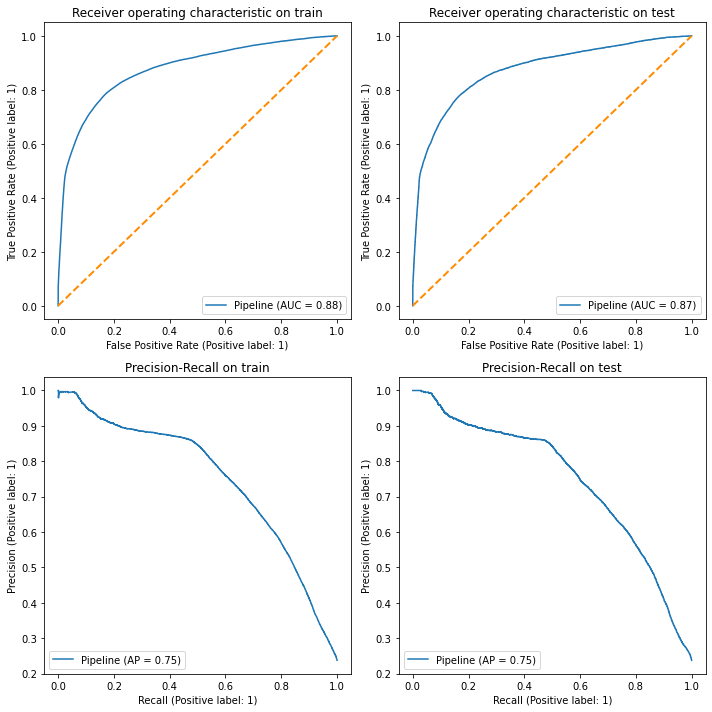

In [62]:
show_performance(grid_result_catc.best_estimator_, X_train, y_train, X_test, y_test)

In [63]:
catc_prediction = catc_pipe.predict_proba(test)[:, 1]
catc_prediction

array([0.15906212, 0.95925675, 0.19468528, ..., 0.26629252, 0.49368704,
       0.17191957])

In [64]:
catc_prediction = pd.DataFrame(catc_prediction, index=test.index, columns=[target_name])
catc_prediction

,Is_Lead
ID,
VBENBARO,0.159062
CCMEWNKY,0.959257
VK3KGA9M,0.194685
TT8RPZVC,0.104144
SHQZEYTZ,0.099026
...,...
DBENJOYI,0.991652
CWQ72DWS,0.816903
HDESC8GU,0.266293


In [65]:
catc_prediction.to_csv("catc_prediction.csv", index=True)

# Stacking

In [66]:
stack = ensemble.StackingClassifier(
    estimators=[('rfc', grid_result_rfc.best_estimator_),
                ('xgb', xgb_pipe),
                ('lgb', grid_result_lgb.best_estimator_),
#                 ('catc', grid_result_catc.best_estimator_),
               ],
    cv=cv,
    n_jobs=-1
)

In [67]:
stack.fit(X_train, y_train)

StackingClassifier(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=42),
                   estimators=[('rfc',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(n_jobs=-1,
                                                                   transformers=[('cat',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value='missing',
                                                                                                                 strategy='constant')),
                                                                                                  ('encoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
           

In [68]:
stack.get_params()

{'cv': RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=42),
 'estimators': [('rfc',
   Pipeline(steps=[('preprocessor',
                    ColumnTransformer(n_jobs=-1,
                                      transformers=[('cat',
                                                     Pipeline(steps=[('imputer',
                                                                      SimpleImputer(fill_value='missing',
                                                                                    strategy='constant')),
                                                                     ('encoder',
                                                                      OneHotEncoder(handle_unknown='ignore',
                                                                                    sparse=False))]),
                                                     ['Gender', 'Region_Code',
                                                      'Occupation', 'Channel_Code',
        

In [69]:
stack.score(X_val, y_val)

0.8577932648285685

Train Score: 0.8582828873740971
Test Score:0.8577932648285685
Train classification Report
              precision    recall  f1-score   support

           0       0.89      0.93      0.91    119960
           1       0.73      0.64      0.68     37304

    accuracy                           0.86    157264
   macro avg       0.81      0.78      0.80    157264
weighted avg       0.85      0.86      0.86    157264

Test classification Report
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     29990
           1       0.72      0.65      0.68      9326

    accuracy                           0.86     39316
   macro avg       0.81      0.79      0.80     39316
weighted avg       0.85      0.86      0.85     39316



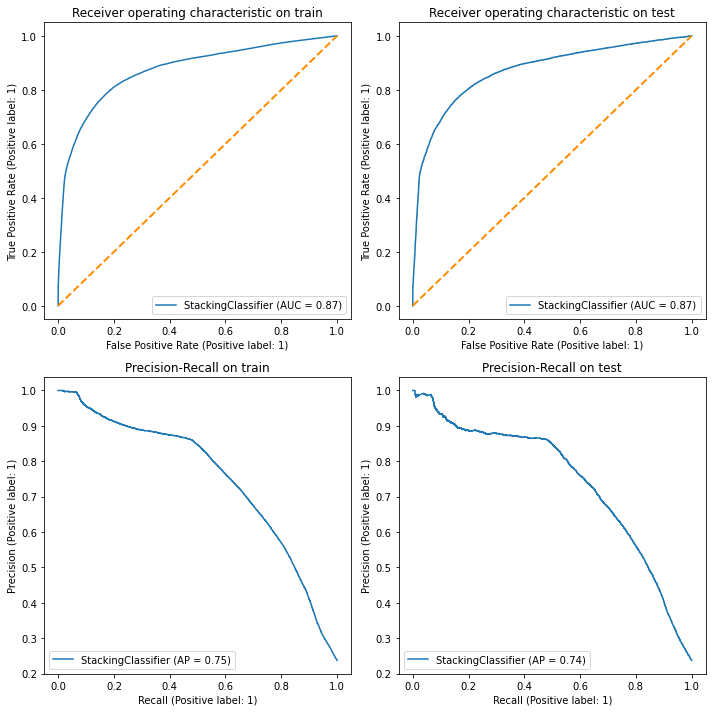

In [70]:
show_performance(stack, X_train, y_train, X_val, y_val)

In [71]:
stack_prediction = stack.predict_proba(test)[:, 1]
stack_prediction

array([0.06543229, 0.81146353, 0.05236919, ..., 0.07129884, 0.25830346,
       0.04092341])

In [72]:
stack_prediction = pd.DataFrame(stack_prediction, index=test.index, columns=[target_name])
stack_prediction

,Is_Lead
ID,
VBENBARO,0.065432
CCMEWNKY,0.811464
VK3KGA9M,0.052369
TT8RPZVC,0.041783
SHQZEYTZ,0.045687
...,...
DBENJOYI,0.839370
CWQ72DWS,0.677742
HDESC8GU,0.071299


In [73]:
stack_prediction.to_csv("stack_prediction.csv", index=True)

# Blending

In [74]:
y_train_pred = grid_result_rfc.best_estimator_.predict_proba(X_train)[:, 1]
# y_train_pred = rfc_pipe.predict(X_train)
y_train_pred = pd.DataFrame(y_train_pred, index=X_train.index, columns=["rfc_pred"])
y_train_pred

,rfc_pred
ID,
7ERQGJWC,0.765956
8RGB5Z5V,0.311178
6U4WQ59E,0.392962
EK7V9USD,0.650526
LVEXWWQ2,0.903424
...,...
EDVF8SHG,0.336828
GVPWZKKA,0.165962
6Z72RZFQ,0.322806


In [75]:
y_val_pred = grid_result_rfc.best_estimator_.predict_proba(X_val)[:, 1]
# y_val_pred = rfc_pipe.predict(X_val)
y_val_pred = pd.DataFrame(y_val_pred, index=X_val.index, columns=["rfc_pred"])
y_val_pred

,rfc_pred
ID,
KXZYOMCQ,0.389865
VB2YV5XS,0.181893
85BTUXCR,0.690531
UFJ3DBKB,0.185828
G8CWZPET,0.310410
...,...
ASEVEHKW,0.417376
DVQHVXJP,0.337067
PBKQMBHE,0.189181


In [76]:
X_test_pred = grid_result_rfc.best_estimator_.predict_proba(X_test)[:, 1]
# X_test_pred = rfc_pipe.predict(X_test)
X_test_pred = pd.DataFrame(X_test_pred, index=X_test.index, columns=["rfc_pred"])
X_test_pred

,rfc_pred
ID,
H5GWINBS,0.183684
R2XAJMBR,0.824340
A7QPJTVZ,0.311319
DNABQIUS,0.417489
R5QVHQP4,0.189539
...,...
DLLZKPF6,0.235096
W4ERVSYO,0.862401
LSKYUD4A,0.323079


In [77]:
rfc_pred = pd.concat([y_train_pred, y_val_pred], axis=0)
rfc_pred

,rfc_pred
ID,
7ERQGJWC,0.765956
8RGB5Z5V,0.311178
6U4WQ59E,0.392962
EK7V9USD,0.650526
LVEXWWQ2,0.903424
...,...
ASEVEHKW,0.417376
DVQHVXJP,0.337067
PBKQMBHE,0.189181


In [78]:
y_train_pred = xgb_pipe.predict_proba(X_train)[:, 1]
# y_train_pred = xgb_pipe.predict(X_train)
y_train_pred = pd.DataFrame(y_train_pred, index=X_train.index, columns=["xgb_pred"])
y_train_pred

,xgb_pred
ID,
7ERQGJWC,0.996390
8RGB5Z5V,0.286872
6U4WQ59E,0.292377
EK7V9USD,0.793693
LVEXWWQ2,0.998706
...,...
EDVF8SHG,0.164408
GVPWZKKA,0.109265
6Z72RZFQ,0.204635


In [79]:
y_val_pred = xgb_pipe.predict_proba(X_val)[:, 1]
# y_val_pred = xgb_pipe.predict(X_val)
y_val_pred = pd.DataFrame(y_val_pred, index=X_val.index, columns=["xgb_pred"])
y_val_pred

,xgb_pred
ID,
KXZYOMCQ,0.344814
VB2YV5XS,0.148204
85BTUXCR,0.803040
UFJ3DBKB,0.166422
G8CWZPET,0.203087
...,...
ASEVEHKW,0.501337
DVQHVXJP,0.259128
PBKQMBHE,0.213924


In [80]:
X_test_pred_temp = xgb_pipe.predict_proba(X_test)[:, 1]
# X_test_pred_temp = lgbm_pipe.predict(X_test)
X_test_pred_temp = pd.DataFrame(X_test_pred_temp, index=X_test.index, columns=["xgb_pred"])
X_test_pred = pd.concat([X_test_pred, X_test_pred_temp], axis=1)
X_test_pred

,rfc_pred,xgb_pred
ID,,
H5GWINBS,0.183684,0.222115
R2XAJMBR,0.824340,0.967224
A7QPJTVZ,0.311319,0.340096
DNABQIUS,0.417489,0.571803
R5QVHQP4,0.189539,0.219187
...,...,...
DLLZKPF6,0.235096,0.203598
W4ERVSYO,0.862401,0.959739
LSKYUD4A,0.323079,0.181039


In [81]:
xgb_pred = pd.concat([y_train_pred, y_val_pred], axis=0)
xgb_pred

,xgb_pred
ID,
7ERQGJWC,0.996390
8RGB5Z5V,0.286872
6U4WQ59E,0.292377
EK7V9USD,0.793693
LVEXWWQ2,0.998706
...,...
ASEVEHKW,0.501337
DVQHVXJP,0.259128
PBKQMBHE,0.213924


In [82]:
y_train_pred = grid_result_lgb.best_estimator_.predict_proba(X_train)[:, 1]
# y_train_pred = lgbm_pipe.predict(X_train)
y_train_pred = pd.DataFrame(y_train_pred, index=X_train.index, columns=["lgb_pred"])
y_train_pred

,lgb_pred
ID,
7ERQGJWC,0.998049
8RGB5Z5V,0.606615
6U4WQ59E,0.618070
EK7V9USD,0.923414
LVEXWWQ2,0.999231
...,...
EDVF8SHG,0.398441
GVPWZKKA,0.281330
6Z72RZFQ,0.441717


In [83]:
y_val_pred = grid_result_lgb.best_estimator_.predict_proba(X_val)[:, 1]
# y_val_pred = lgbm_pipe.predict(X_val)
y_val_pred = pd.DataFrame(y_val_pred, index=X_val.index, columns=["lgb_pred"])
y_val_pred

,lgb_pred
ID,
KXZYOMCQ,0.603573
VB2YV5XS,0.331712
85BTUXCR,0.934442
UFJ3DBKB,0.387040
G8CWZPET,0.453843
...,...
ASEVEHKW,0.733484
DVQHVXJP,0.542867
PBKQMBHE,0.484928


In [84]:
X_test_pred_temp = grid_result_lgb.best_estimator_.predict_proba(X_test)[:, 1]
# X_test_pred_temp = lgbm_pipe.predict(X_test)
X_test_pred_temp = pd.DataFrame(X_test_pred_temp, index=X_test.index, columns=["lgb_pred"])
X_test_pred = pd.concat([X_test_pred, X_test_pred_temp], axis=1)
X_test_pred

,rfc_pred,xgb_pred,lgb_pred
ID,,,
H5GWINBS,0.183684,0.222115,0.484283
R2XAJMBR,0.824340,0.967224,0.988853
A7QPJTVZ,0.311319,0.340096,0.619621
DNABQIUS,0.417489,0.571803,0.812424
R5QVHQP4,0.189539,0.219187,0.475378
...,...,...,...
DLLZKPF6,0.235096,0.203598,0.489037
W4ERVSYO,0.862401,0.959739,0.987707
LSKYUD4A,0.323079,0.181039,0.424533


In [85]:
lgb_pred = pd.concat([y_train_pred, y_val_pred], axis=0)
lgb_pred

,lgb_pred
ID,
7ERQGJWC,0.998049
8RGB5Z5V,0.606615
6U4WQ59E,0.618070
EK7V9USD,0.923414
LVEXWWQ2,0.999231
...,...
ASEVEHKW,0.733484
DVQHVXJP,0.542867
PBKQMBHE,0.484928


In [86]:
y_train_pred = grid_result_catc.best_estimator_.predict_proba(X_train)[:, 1]
# y_train_pred = catc.predict_proba(X_train_1)[:, 1]
# y_train_pred = catc.predict(X_train_1)
y_train_pred = pd.DataFrame(y_train_pred, index=X_train.index, columns=["cat_pred"])
y_train_pred

,cat_pred
ID,
7ERQGJWC,0.987139
8RGB5Z5V,0.242444
6U4WQ59E,0.274647
EK7V9USD,0.748150
LVEXWWQ2,0.993066
...,...
EDVF8SHG,0.164364
GVPWZKKA,0.085843
6Z72RZFQ,0.173520


In [87]:
y_val_pred = grid_result_catc.best_estimator_.predict_proba(X_val)[:, 1]
# y_val_pred = catc.predict_proba(X_val_1)[:, 1]
# y_val_pred = catc.predict(X_val_1)
y_val_pred = pd.DataFrame(y_val_pred, index=X_val.index, columns=["cat_pred"])
y_val_pred

,cat_pred
ID,
KXZYOMCQ,0.300410
VB2YV5XS,0.114777
85BTUXCR,0.799882
UFJ3DBKB,0.137662
G8CWZPET,0.170773
...,...
ASEVEHKW,0.430391
DVQHVXJP,0.241002
PBKQMBHE,0.185289


In [88]:
X_test_pred_temp = grid_result_catc.best_estimator_.predict_proba(X_test)[:, 1]
# X_test_pred_temp = catc.predict_proba(X_test_1)[:, 1]
# X_test_pred_temp = catc.predict(X_test_1)
X_test_pred_temp = pd.DataFrame(X_test_pred_temp, index=X_test.index, columns=["cat_pred"])
X_test_pred = pd.concat([X_test_pred, X_test_pred_temp], axis=1)
X_test_pred

,rfc_pred,xgb_pred,lgb_pred,cat_pred
ID,,,,
H5GWINBS,0.183684,0.222115,0.484283,0.174502
R2XAJMBR,0.824340,0.967224,0.988853,0.961192
A7QPJTVZ,0.311319,0.340096,0.619621,0.301041
DNABQIUS,0.417489,0.571803,0.812424,0.509988
R5QVHQP4,0.189539,0.219187,0.475378,0.188577
...,...,...,...,...
DLLZKPF6,0.235096,0.203598,0.489037,0.169817
W4ERVSYO,0.862401,0.959739,0.987707,0.950580
LSKYUD4A,0.323079,0.181039,0.424533,0.162530


In [89]:
# X_test_pred = pd.concat([X_test_pred, X_test], axis=1)
# X_test_pred

In [90]:
cat_pred = pd.concat([y_train_pred, y_val_pred], axis=0)
cat_pred

,cat_pred
ID,
7ERQGJWC,0.987139
8RGB5Z5V,0.242444
6U4WQ59E,0.274647
EK7V9USD,0.748150
LVEXWWQ2,0.993066
...,...
ASEVEHKW,0.430391
DVQHVXJP,0.241002
PBKQMBHE,0.185289


In [91]:
X_pred = pd.concat([rfc_pred, xgb_pred, lgb_pred, cat_pred], axis=1)
X_pred

,rfc_pred,xgb_pred,lgb_pred,cat_pred
ID,,,,
7ERQGJWC,0.765956,0.996390,0.998049,0.987139
8RGB5Z5V,0.311178,0.286872,0.606615,0.242444
6U4WQ59E,0.392962,0.292377,0.618070,0.274647
EK7V9USD,0.650526,0.793693,0.923414,0.748150
LVEXWWQ2,0.903424,0.998706,0.999231,0.993066
...,...,...,...,...
ASEVEHKW,0.417376,0.501337,0.733484,0.430391
DVQHVXJP,0.337067,0.259128,0.542867,0.241002
PBKQMBHE,0.189181,0.213924,0.484928,0.185289


In [92]:
# X_pred = pd.concat([X_pred, pd.concat([X_train, X_val])], axis=1)
# X_pred

In [93]:
y_pred = pd.concat([y_train, y_val], axis=0)
y_pred

ID
7ERQGJWC    1
8RGB5Z5V    0
6U4WQ59E    0
EK7V9USD    1
LVEXWWQ2    1
           ..
ASEVEHKW    0
DVQHVXJP    0
PBKQMBHE    0
PENKEXVZ    1
GSKFW3O8    0
Name: Is_Lead, Length: 196580, dtype: int64

In [94]:
test_pred = grid_result_rfc.best_estimator_.predict_proba(test)[:, 1]
# test_pred = xgb_pipe.predict(test)
test_pred = pd.DataFrame(test_pred, index=test.index, columns=["rfc_pred"])
test_pred

,rfc_pred
ID,
VBENBARO,0.331531
CCMEWNKY,0.817885
VK3KGA9M,0.178541
TT8RPZVC,0.164375
SHQZEYTZ,0.149533
...,...
DBENJOYI,0.778828
CWQ72DWS,0.660741
HDESC8GU,0.335591


In [95]:
test_pred_temp = xgb_pipe.predict_proba(test)[:, 1]
# test_pred = xgb_pipe.predict(test)
test_pred_temp = pd.DataFrame(test_pred_temp, index=test.index, columns=["xgb_pred"])
test_pred = pd.concat([test_pred, test_pred_temp], axis=1)
test_pred

,rfc_pred,xgb_pred
ID,,
VBENBARO,0.331531,0.227542
CCMEWNKY,0.817885,0.969518
VK3KGA9M,0.178541,0.243836
TT8RPZVC,0.164375,0.110443
SHQZEYTZ,0.149533,0.109376
...,...,...
DBENJOYI,0.778828,0.995679
CWQ72DWS,0.660741,0.869927
HDESC8GU,0.335591,0.284893


In [96]:
test_pred_temp = grid_result_lgb.best_estimator_.predict_proba(test)[:, 1]
# test_pred_temp = lgbm_pipe.predict(test)
test_pred_temp = pd.DataFrame(test_pred_temp, index=test.index, columns=["lgb_pred"])
test_pred = pd.concat([test_pred, test_pred_temp], axis=1)
test_pred

,rfc_pred,xgb_pred,lgb_pred
ID,,,
VBENBARO,0.331531,0.227542,0.422256
CCMEWNKY,0.817885,0.969518,0.990041
VK3KGA9M,0.178541,0.243836,0.492809
TT8RPZVC,0.164375,0.110443,0.290302
SHQZEYTZ,0.149533,0.109376,0.268369
...,...,...,...
DBENJOYI,0.778828,0.995679,0.997792
CWQ72DWS,0.660741,0.869927,0.942401
HDESC8GU,0.335591,0.284893,0.509803


In [97]:
test_pred_temp = grid_result_catc.best_estimator_.predict_proba(test)[:, 1]
# test_pred_temp = catc.predict_proba(test.fillna("missing"))[:, 1]
# test_pred_temp = catc.predict(test.fillna("missing"))
test_pred_temp = pd.DataFrame(test_pred_temp, index=test.index, columns=["cat_pred"])
test_pred = pd.concat([test_pred, test_pred_temp], axis=1)
test_pred

,rfc_pred,xgb_pred,lgb_pred,cat_pred
ID,,,,
VBENBARO,0.331531,0.227542,0.422256,0.196895
CCMEWNKY,0.817885,0.969518,0.990041,0.957348
VK3KGA9M,0.178541,0.243836,0.492809,0.189096
TT8RPZVC,0.164375,0.110443,0.290302,0.092168
SHQZEYTZ,0.149533,0.109376,0.268369,0.092142
...,...,...,...,...
DBENJOYI,0.778828,0.995679,0.997792,0.989356
CWQ72DWS,0.660741,0.869927,0.942401,0.827915
HDESC8GU,0.335591,0.284893,0.509803,0.259719


In [98]:
# test_pred = pd.concat([test_pred, test], axis=1)
# test_pred

In [99]:
steps = [
#     ('preprocessor', preprocessor),
    ('reduced_dim', PCA(0.95)),
    ('lr', linear_model.LogisticRegression(n_jobs=-1, class_weight='balanced'))
]
lr_pipe = Pipeline(steps)
lr_pipe.fit(X_pred, y_pred)

Pipeline(steps=[('reduced_dim', PCA(n_components=0.95)),
                ('lr', LogisticRegression(class_weight='balanced', n_jobs=-1))])

Train Score: 0.8009868755722861
Test Score:0.8003866110489368
Train classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86    149950
           1       0.56      0.81      0.66     46630

    accuracy                           0.80    196580
   macro avg       0.74      0.80      0.76    196580
weighted avg       0.84      0.80      0.81    196580

Test classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     37487
           1       0.55      0.80      0.66     11658

    accuracy                           0.80     49145
   macro avg       0.74      0.80      0.76     49145
weighted avg       0.84      0.80      0.81     49145



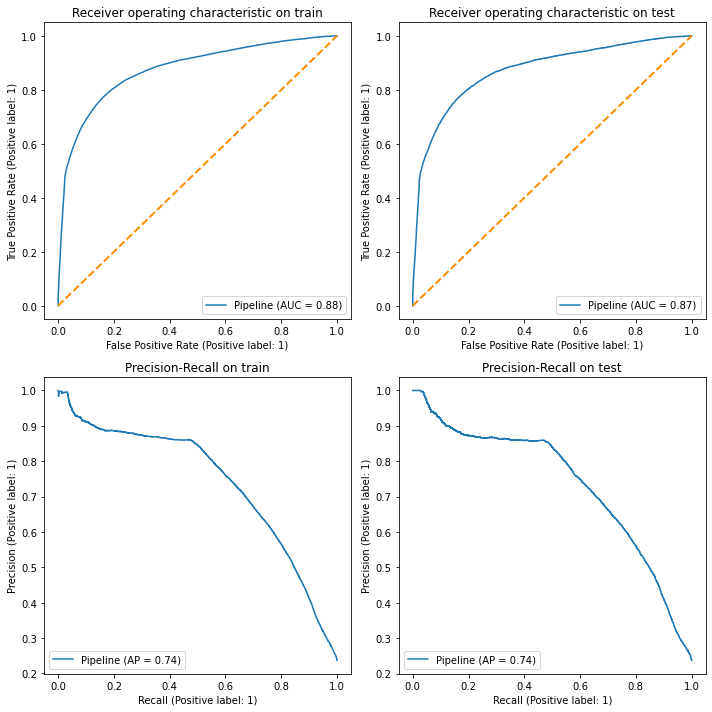

In [100]:
show_performance(lr_pipe, X_pred, y_pred, X_test_pred, y_test)

In [101]:
# define grid search
grid = {
#     'lr__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]
}
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=2, random_state=42)
grid_search = GridSearchCV(estimator=lr_pipe, param_grid=grid, n_jobs=-1,
                           cv=cv,scoring=scoring, error_score=0, verbose=1)
grid_result_lr = grid_search.fit(X_pred, y_pred)


Fitting 10 folds for each of 14 candidates, totalling 140 fits


Train Score: 0.8753752360229876
Test Score:0.8730948556476303
Train classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86    149950
           1       0.56      0.81      0.66     46630

    accuracy                           0.80    196580
   macro avg       0.74      0.80      0.76    196580
weighted avg       0.84      0.80      0.81    196580

Test classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     37487
           1       0.55      0.80      0.66     11658

    accuracy                           0.80     49145
   macro avg       0.74      0.80      0.76     49145
weighted avg       0.84      0.80      0.81     49145



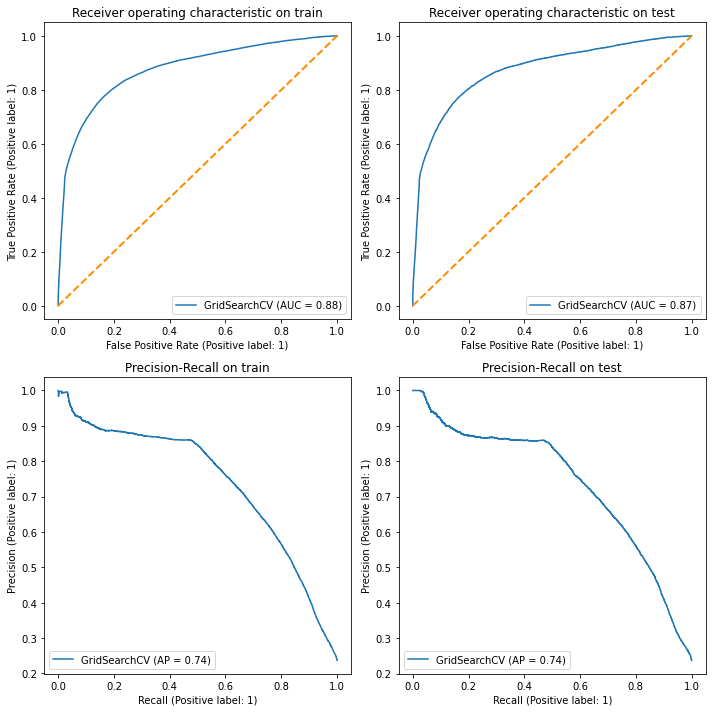

In [102]:
show_performance(grid_result_lr, X_pred, y_pred, X_test_pred, y_test)

In [103]:
blend_pred = grid_result_lr.predict_proba(test_pred)[:, 1]
blend_pred

array([0.13693858, 0.90669092, 0.12600123, ..., 0.18221413, 0.51993854,
       0.11517092])

In [104]:
blend_pred = pd.DataFrame(blend_pred, index=test.index, columns=[target_name])
blend_pred

,Is_Lead
ID,
VBENBARO,0.136939
CCMEWNKY,0.906691
VK3KGA9M,0.126001
TT8RPZVC,0.066418
SHQZEYTZ,0.063268
...,...
DBENJOYI,0.911773
CWQ72DWS,0.830212
HDESC8GU,0.182214


In [105]:
blend_pred.to_csv("blend_prediction.csv", index=True)

In [106]:
X_train_catc_pred = grid_result_catc.best_estimator_.predict_proba(X_train)[:, 1]
X_train_catc_pred

array([0.98713898, 0.24244404, 0.27464722, ..., 0.17351963, 0.62995772,
       0.94912982])

In [107]:
X_train_catc_pred = pd.DataFrame(X_train_catc_pred, index=X_train.index, columns=["catc_pred"])

In [108]:
X_val_catc_pred = grid_result_catc.best_estimator_.predict_proba(X_val)[:, 1]
X_val_catc_pred

array([0.30040964, 0.11477658, 0.79988177, ..., 0.18528903, 0.97116233,
       0.33381508])

In [109]:
X_val_catc_pred = pd.DataFrame(X_val_catc_pred, index=X_val.index, columns=["catc_pred"])

In [110]:
X_test_catc_pred = grid_result_catc.best_estimator_.predict_proba(X_test)[:, 1]
X_test_catc_pred

array([0.17450249, 0.96119225, 0.30104131, ..., 0.16252967, 0.97502574,
       0.35852325])

In [111]:
X_test_catc_pred = pd.DataFrame(X_test_catc_pred, index=X_test.index, columns=["catc_pred"])

In [112]:
test_catc_pred = grid_result_catc.best_estimator_.predict_proba(test)[:,1]

In [113]:
test_catc_pred = pd.DataFrame(test_catc_pred, index=test.index, columns=["catc_pred"])

In [114]:
X_train_stack_pred = stack.predict_proba(X_train)[:, 1]
X_train_stack_pred

array([0.83946134, 0.04700248, 0.04853452, ..., 0.04958764, 0.31570291,
       0.80374042])

In [115]:
X_train_stack_pred = pd.DataFrame(X_train_stack_pred, index=X_train.index, columns=["stack_pred"])

In [116]:
X_val_stack_pred = stack.predict_proba(X_val)[:, 1]
X_val_stack_pred

array([0.08030081, 0.04813714, 0.54887927, ..., 0.04224966, 0.81848278,
       0.07834208])

In [117]:
X_val_stack_pred = pd.DataFrame(X_val_stack_pred, index=X_val.index, columns=["stack_pred"])

In [118]:
X_test_stack_pred = stack.predict_proba(X_test)[:, 1]
X_test_stack_pred

array([0.04542866, 0.80928249, 0.07004421, ..., 0.04387827, 0.81576737,
       0.10380897])

In [119]:
X_test_stack_pred = pd.DataFrame(X_test_stack_pred, index=X_test.index, columns=["stack_pred"])

In [120]:
test_stack_pred = stack.predict_proba(test)[:,1]

In [121]:
test_stack_pred = pd.DataFrame(test_stack_pred, index=test.index, columns=["stack_pred"])

In [122]:
train_catc_pred = pd.concat([X_train_catc_pred, X_val_catc_pred])
train_stack_pred = pd.concat([X_train_stack_pred, X_val_stack_pred])
train_pred = pd.concat([train_catc_pred, train_stack_pred], axis=1)

In [130]:
to_test_pred = pd.concat([X_test_catc_pred, X_test_stack_pred], axis=1)

In [123]:
test_pred = pd.concat([test_catc_pred, test_stack_pred], axis=1)

In [126]:
train_pred

,catc_pred,stack_pred
ID,,
7ERQGJWC,0.987139,0.839461
8RGB5Z5V,0.242444,0.047002
6U4WQ59E,0.274647,0.048535
EK7V9USD,0.748150,0.536212
LVEXWWQ2,0.993066,0.846468
...,...,...
ASEVEHKW,0.430391,0.161931
DVQHVXJP,0.241002,0.050129
PBKQMBHE,0.185289,0.042250


In [129]:
y_pred

ID
7ERQGJWC    1
8RGB5Z5V    0
6U4WQ59E    0
EK7V9USD    1
LVEXWWQ2    1
           ..
ASEVEHKW    0
DVQHVXJP    0
PBKQMBHE    0
PENKEXVZ    1
GSKFW3O8    0
Name: Is_Lead, Length: 196580, dtype: int64

In [131]:
to_test_pred

,catc_pred,stack_pred
ID,,
H5GWINBS,0.174502,0.045429
R2XAJMBR,0.961192,0.809282
A7QPJTVZ,0.301041,0.070044
DNABQIUS,0.509988,0.199820
R5QVHQP4,0.188577,0.046216
...,...,...
DLLZKPF6,0.169817,0.038516
W4ERVSYO,0.950580,0.801389
LSKYUD4A,0.162530,0.043878


In [128]:
y_

ID
H5GWINBS    0
R2XAJMBR    1
A7QPJTVZ    0
DNABQIUS    0
R5QVHQP4    0
           ..
DLLZKPF6    0
W4ERVSYO    1
LSKYUD4A    0
CHSCGQTW    1
98KUMR7G    0
Name: Is_Lead, Length: 49145, dtype: int64

In [124]:
steps = [
#     ('preprocessor', preprocessor),
    ('reduced_dim', PCA(0.95)),
    ('lr', linear_model.LogisticRegression(n_jobs=-1, class_weight='balanced'))
]
lr_pipe = Pipeline(steps)
lr_pipe.fit(train_pred, y_pred)

Pipeline(steps=[('reduced_dim', PCA(n_components=0.95)),
                ('lr', LogisticRegression(class_weight='balanced', n_jobs=-1))])

Train Score: 0.8265133787770882
Test Score:0.825984332078543
Train classification Report
              precision    recall  f1-score   support

           0       0.92      0.85      0.88    149950
           1       0.61      0.77      0.68     46630

    accuracy                           0.83    196580
   macro avg       0.76      0.81      0.78    196580
weighted avg       0.85      0.83      0.83    196580

Test classification Report
              precision    recall  f1-score   support

           0       0.92      0.85      0.88     37487
           1       0.61      0.76      0.67     11658

    accuracy                           0.83     49145
   macro avg       0.76      0.80      0.78     49145
weighted avg       0.84      0.83      0.83     49145



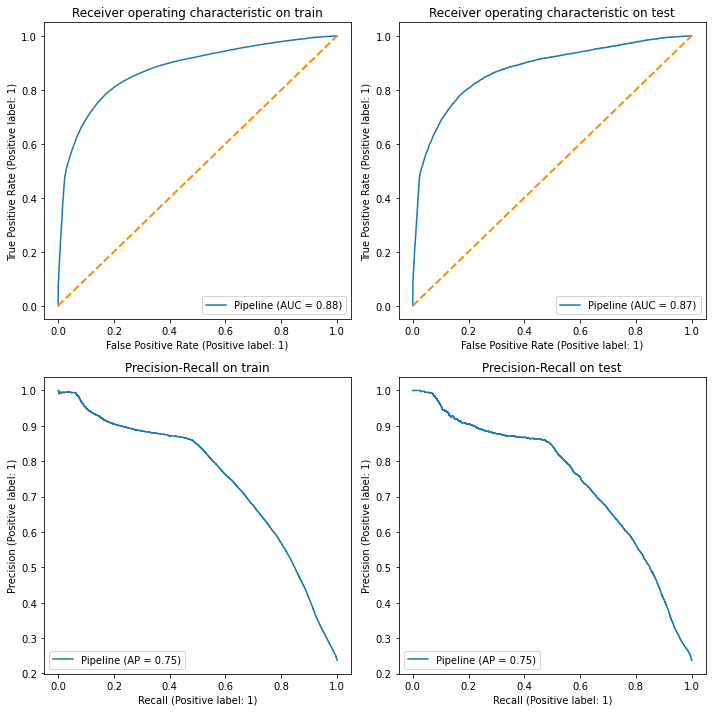

In [132]:
show_performance(lr_pipe, train_pred, y_pred, to_test_pred, y_test)

In [133]:
# define grid search
grid = {
#     'lr__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]
}
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=2, random_state=42)
grid_search = GridSearchCV(estimator=lr_pipe, param_grid=grid, n_jobs=-1,
                           cv=cv,scoring=scoring, error_score=0, verbose=1)
grid_result_lr = grid_search.fit(train_pred, y_pred)


Fitting 10 folds for each of 14 candidates, totalling 140 fits


Train Score: 0.8265133787770882
Test Score:0.825984332078543
Train classification Report
              precision    recall  f1-score   support

           0       0.92      0.85      0.88    149950
           1       0.61      0.77      0.68     46630

    accuracy                           0.83    196580
   macro avg       0.76      0.81      0.78    196580
weighted avg       0.85      0.83      0.83    196580

Test classification Report
              precision    recall  f1-score   support

           0       0.92      0.85      0.88     37487
           1       0.61      0.76      0.67     11658

    accuracy                           0.83     49145
   macro avg       0.76      0.80      0.78     49145
weighted avg       0.84      0.83      0.83     49145



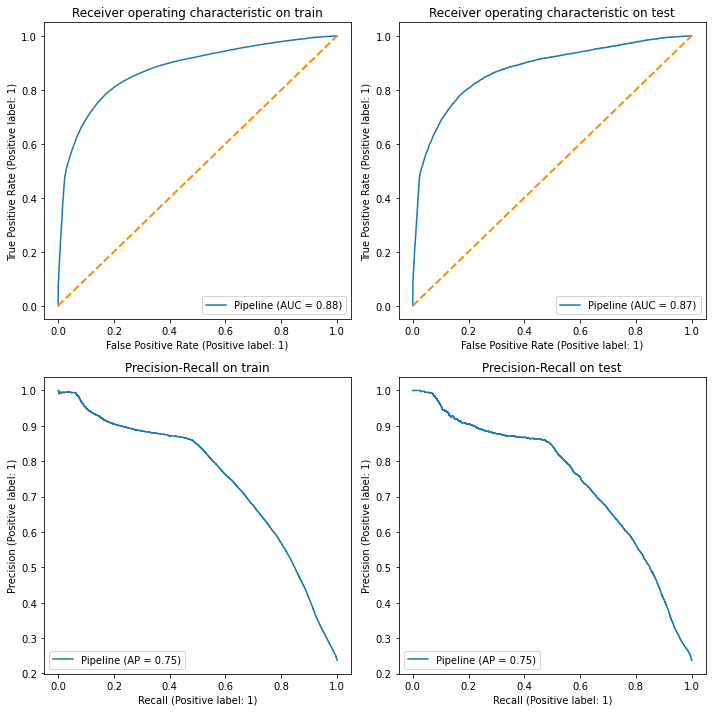

In [134]:
show_performance(grid_result_lr.best_estimator_, train_pred, y_pred, to_test_pred, y_test)

In [136]:
combination_prediction = grid_result_lr.best_estimator_.predict_proba(test_pred)[:, 1]
combination_prediction

array([0.16312971, 0.93499424, 0.15523365, ..., 0.19259345, 0.46346898,
       0.15179206])

In [137]:
combination_prediction = pd.DataFrame(combination_prediction, columns=[target_name], index=test.index)
combination_prediction

,Is_Lead
ID,
VBENBARO,0.163130
CCMEWNKY,0.934994
VK3KGA9M,0.155234
TT8RPZVC,0.118176
SHQZEYTZ,0.119292
...,...
DBENJOYI,0.944668
CWQ72DWS,0.871627
HDESC8GU,0.192593


In [138]:
combination_prediction.to_csv("combination_prediction.csv", index=True)